In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
from astropy import units as u
from matplotlib.pyplot import figure, show
from pathlib import Path
import pandas as pd
import seaborn as sns
import corner
import lifesim
from scipy.stats import gaussian_kde

In [2]:
print(os.getcwd())
os.chdir('/net/virgo01/data/users/cesario/Retrievals-on-forward')
print(os.getcwd())

/Users/users/cesario/venvs/lifesim/lib/python3.8/site-packages/lifesim/gui
/net/virgo01/data/users/cesario/Retrievals-on-forward


## Functions

In [3]:
def read_dat_file_with_headers(file_path):
    data = np.loadtxt(file_path, comments='#')
    temperature = data[:, 0]
    pressure = data[:, 1]
    noise = data[:,2]
    return temperature, pressure, noise

def limits_function(file_path):
    data = np.loadtxt(file_path, comments='#')
    return tuple(data[:, i] for i in range(data.shape[1]))

def noack_files(filename):
    data = np.loadtxt(f"Figure2/{filename}",delimiter=',')
    return tuple(data[:,i] for i in range(data.shape[0]))

def posterior_distributions(filename):
    data = np.loadtxt(filename, comments='#')
    return tuple(data[:, i] for i in range(data.shape[1]))

def noack_files_3(filename):
    data = np.loadtxt(f"Figure3/{filename}",delimiter=',')
    return tuple(data[:,i] for i in range(data.shape[0]))

## Figure 1

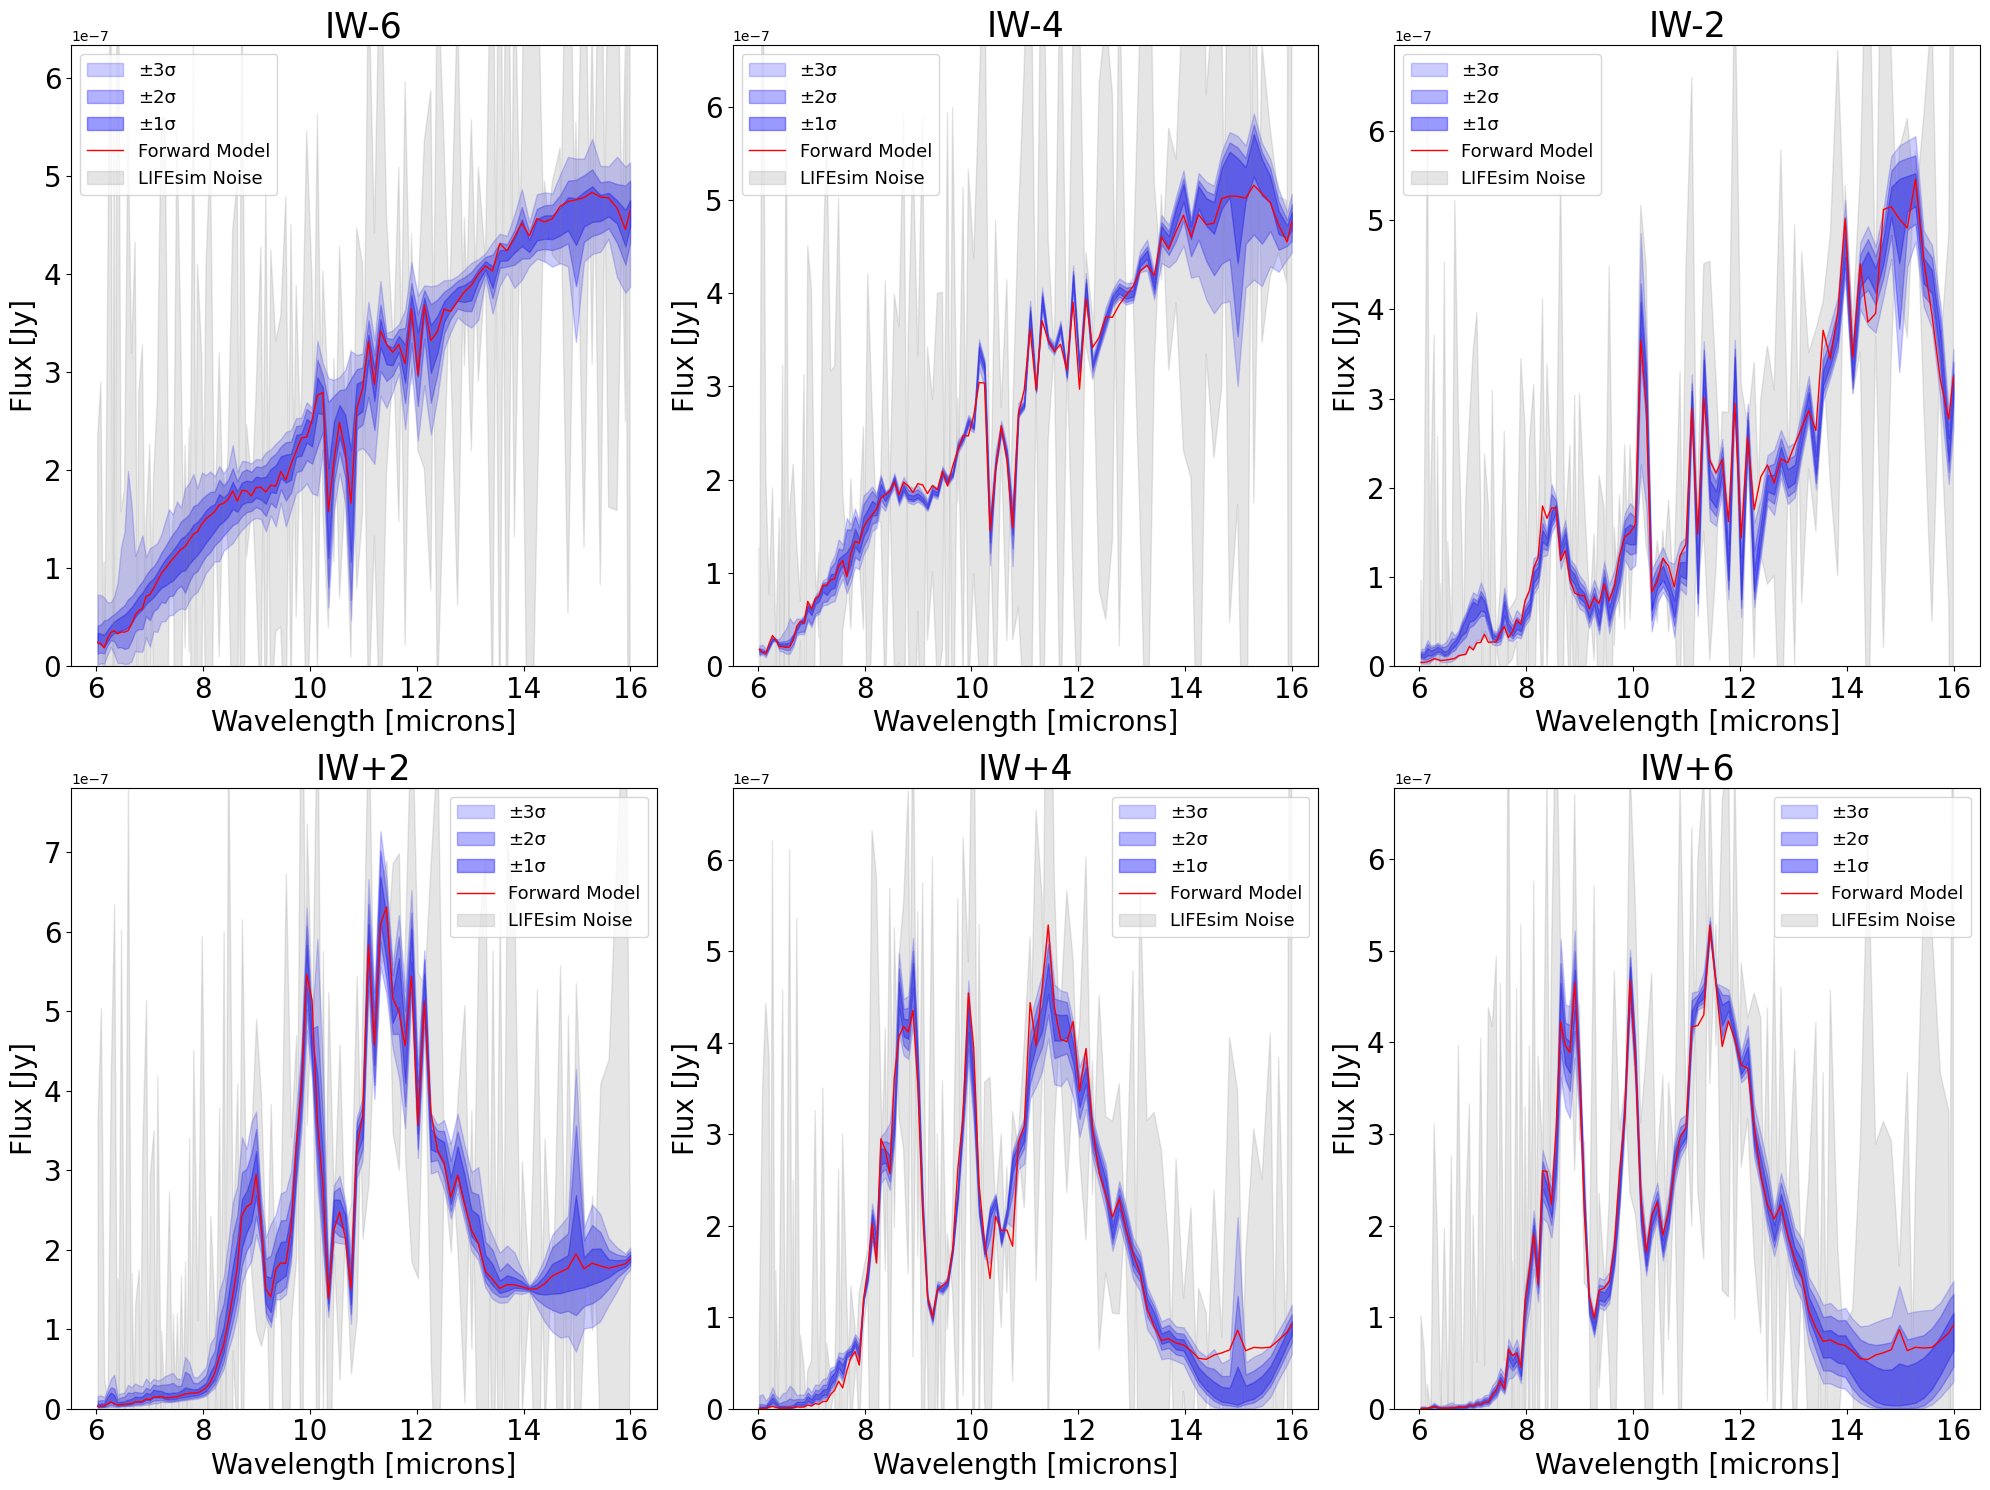

In [4]:
emissions = np.zeros([6, 99])
name = []
temp = '300'
custom_order = [f'NO_S_-6_600',f'NO_S_-4_600',f'NO_S_-2_600', f'NO_S_2_600',f'NO_S_4_600',f'NO_S_6_600']
fluxes = [read_dat_file_with_headers("Fluxes/NO_S_-6_600")[1][:],
          read_dat_file_with_headers("Fluxes/NO_S_-4_600")[1][:],
          read_dat_file_with_headers("Fluxes/NO_S_-2_600")[1][:],
          read_dat_file_with_headers("Fluxes/NO_S_2_600")[1][:],
          read_dat_file_with_headers("Fluxes/NO_S_4_600")[1][:],
          read_dat_file_with_headers("Fluxes/NO_S_6_600")[1][:]]

noises = [read_dat_file_with_headers("Fluxes/NO_S_-6_600")[2],
          read_dat_file_with_headers("Fluxes/NO_S_-4_600")[2],
          read_dat_file_with_headers("Fluxes/NO_S_-2_600")[2],
          read_dat_file_with_headers("Fluxes/NO_S_2_600")[2],
          read_dat_file_with_headers("Fluxes/NO_S_4_600")[2],
          read_dat_file_with_headers("Fluxes/NO_S_6_600")[2]]


for i, dir_name in enumerate(custom_order):
    if os.path.isdir(dir_name):
        wavelengths, emission_data, _ = read_dat_file_with_headers(f"{dir_name}/emis")
        emissions[i, :] = emission_data
        name.append(dir_name)

fig = plt.figure(figsize=(20, 15))

for n in range(6):
    frame = fig.add_subplot(2, 3, n+1)
    filename = "emis_limits"
    filepath = Path(custom_order[n]) / filename
    if filepath.exists():
        wavelength, m3_sigma, m2_sigma, m_sigma, value, p1_sigma, p2_sigma, p3_sigma = limits_function(f"{custom_order[n]}/emis_limits")
        frame.fill_between(wavelength, m3_sigma,p3_sigma, color='blue', alpha=0.2, label='±3σ')
        frame.fill_between(wavelength, m2_sigma,p2_sigma, color='blue', alpha=0.3, label='±2σ')
        frame.fill_between(wavelength, m_sigma,p1_sigma, color='blue', alpha=0.4, label='±1σ')
        #frame.plot(wavelength,value,label="ARCiS",c='red')
        #frame.plot(wavelength,emissions[n],label="ARCiS",c='black')
    else:
        frame.plot(wavelength,emissions[n],label="ARCiS",c='black')

    frame.plot(wavelengths, fluxes[n],label='Forward Model',c='red',linewidth=1)
    #LIFEsim noise
    frame.fill_between(wavelength, fluxes[n]-noises[n],fluxes[n]+noises[n],color='gray',alpha=0.2,label='LIFEsim Noise')
    #frame.scatter(wavelength, noises[n],color='gray')
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    frame.set_title(f"IW{name[n][5:-4]}",fontsize=25)
    if n >= 3:
        frame.set_title(f"IW+{name[n][5:-4]}",fontsize=25)
    frame.set_xlabel("Wavelength [microns]",fontsize=20)
    frame.set_ylabel("Flux [Jy]",fontsize=20)
    frame.tick_params(axis='both',labelsize=20)
    frame.set_ylim(0, np.max(fluxes[n]+0.15e-6)); 
    #frame.set_yscale('log')
    frame.legend(fontsize=13)

plt.tight_layout() 
plt.savefig('Images/pew_emissions.pdf', format='pdf')
show()

## Figure 2

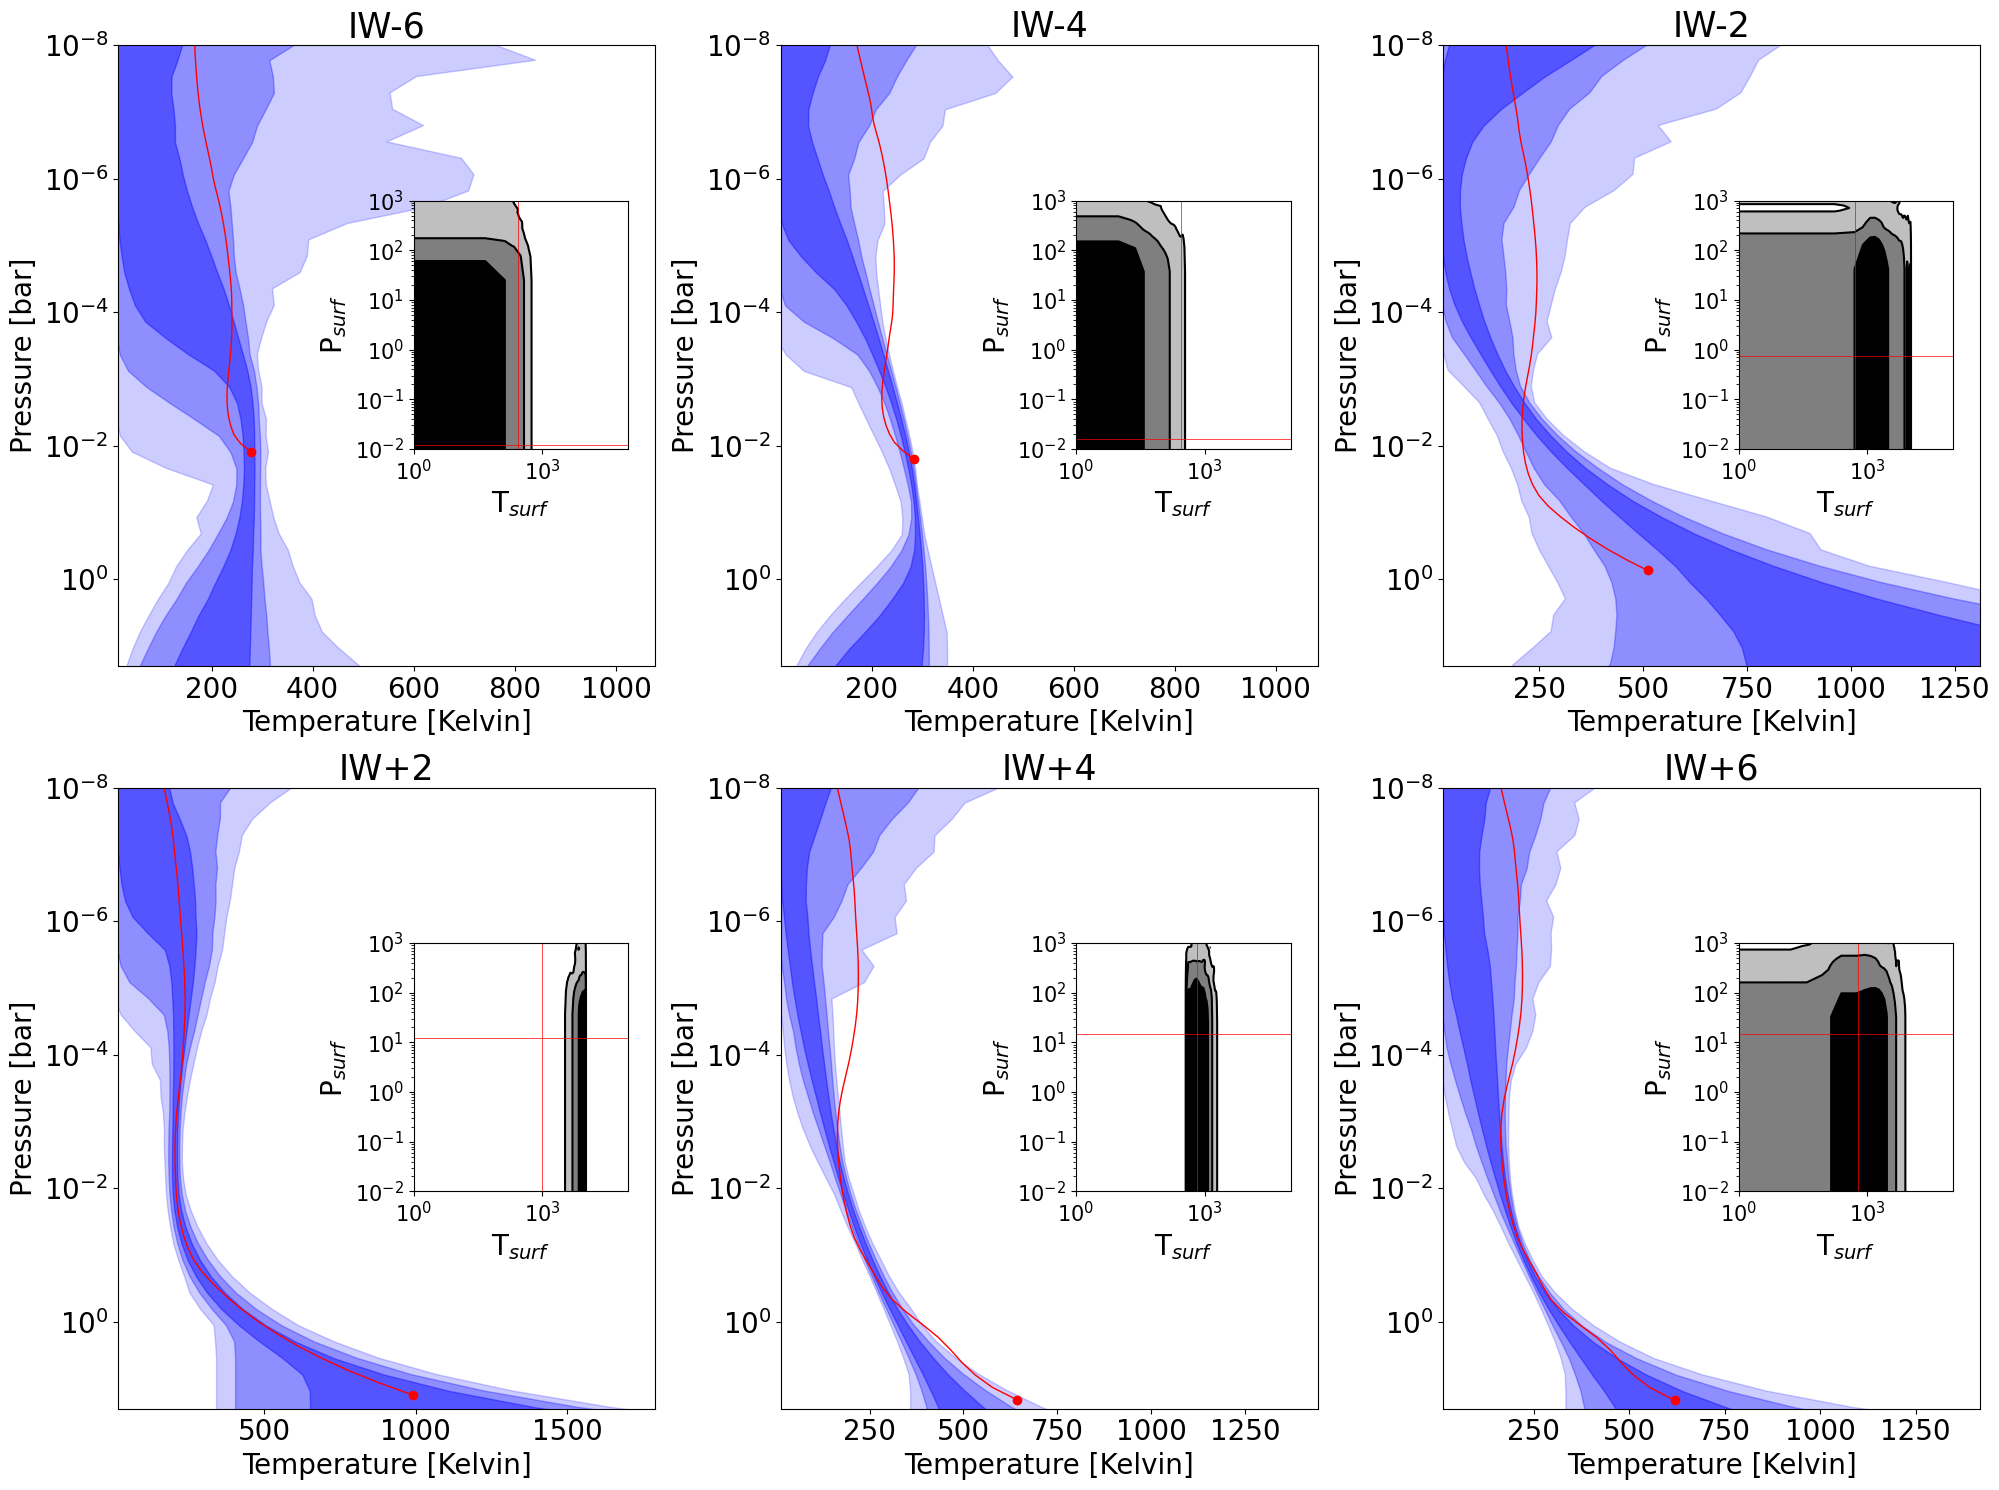

In [15]:
pressures = np.zeros([6, 50])
temperatures = np.zeros([6, 50])
profiles = np.zeros([6, 50])
name = []

custom_order_forward = ['NO_S_-6_600', 'NO_S_-4_600', 'NO_S_-2_600', 'NO_S_2_600', 'NO_S_4_600', 'NO_S_6_600']
custom_order = ['NO_S_-6_600', 'NO_S_-4_600', 'NO_S_-2_600', 
                'NO_S_2_600', 'NO_S_4_600', 'NO_S_6_600']

for i, dir_name in enumerate(custom_order_forward):
    temperature, pressure, _ = read_dat_file_with_headers(f"Forward-Files/{dir_name}/mixingratios.dat")
    temperatures[i, :] = temperature
    pressures[i, :] = pressure
    name.append(dir_name)

#figure
fig = plt.figure(figsize=(20, 15))

for n in range(6):
    frame = fig.add_subplot(2, 3, n + 1)
    
    #forward model
    frame.plot(temperatures[n], pressures[n], label='Forward-model', c='red', linewidth=1)

    filename = "PT_limits"
    filepath = Path(custom_order[n]) / filename

    #ARCiS posterior data
    if filepath.exists():
        pres, m3_sigma, m2_sigma, m_sigma, temp, p1_sigma, p2_sigma, p3_sigma = limits_function(f"{custom_order[n]}/PT_limits")
        
        #posterior distributions
        post_data = posterior_distributions(f"{custom_order[n]}/pew_output.dat")
        T_surf = 10 ** (post_data[14][:])

        H2_dist  = 10**post_data[1][:]
        H2O_dist = 10**post_data[2][:]
        NH3_dist = 10**post_data[5][:]
        N2_dist  = 10**post_data[6][:]
        CH4_dist = 10**post_data[4][:]
        CO2_dist = 10**post_data[3][:]

        posterior_pp = np.vstack([H2_dist, H2O_dist, NH3_dist, 
                          N2_dist, CH4_dist, CO2_dist]).T

        total_pp_samples = np.sum(posterior_pp, axis=1)
        total_pp_log = np.log10(total_pp_samples)

        p_1sig = np.percentile(total_pp_log, [16, 84])
        p_2sig = np.percentile(total_pp_log, [2.5, 97.5])
        p_3sig = np.percentile(total_pp_log, [0.15, 99.85])

        pres_log = np.log10(pres)
        mask_3sig = pres_log <= p_3sig[1]
        mask_2sig = pres_log <= p_2sig[1]
        mask_1sig = pres_log <= p_1sig[1]

        frame.fill_betweenx(pres[mask_3sig], m3_sigma[mask_3sig], p3_sigma[mask_3sig], color='blue', alpha=0.2, label='±3σ')
        frame.fill_betweenx(pres[mask_2sig], m2_sigma[mask_2sig], p2_sigma[mask_2sig], color='blue', alpha=0.3, label='±2σ')
        frame.fill_betweenx(pres[mask_1sig], m_sigma[mask_1sig], p1_sigma[mask_1sig], color='blue', alpha=0.4, label='±1σ')
    else:
        temp, pres, _ = read_dat_file_with_headers(f"{custom_order[n]}/mixingratios.dat")
        frame.plot(temp, pres, label="ARCiS", c='red')

    #asymmetric x-range to make space for inset
    offset_left = 150
    offset_right = 800  # more space on the right
    x_min = int(np.min(temperatures[n]) - offset_left)
    x_max = int(np.max(temperatures[n]) + offset_right)
    frame.set_xlim(x_min, x_max)

    #adjust y-limits
    if filepath.exists():
        total_pp_samples = H2_dist + H2O_dist + NH3_dist + N2_dist + CH4_dist + CO2_dist
        median_surfP = np.median(total_pp_samples)
        frame.set_ylim(1e-8,20)
        directory = custom_order[n]
        temp_real, pres_real, _ = read_dat_file_with_headers(f"Forward-Files/{directory}/mixingratios.dat")
        T_real = np.max(temp_real)
        P_real = np.max(pres_real)
        frame.scatter(T_real,P_real,color='red')
    else:
        frame.set_ylim(np.min(pres), np.max(pres))

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    frame.set_title(f"IW{name[n][5:-4]}",fontsize=25)
    if n >= 3:
        frame.set_title(f"IW+{name[n][5:-4]}",fontsize=25)
    frame.set_xlabel("Temperature [Kelvin]",fontsize=20)
    frame.set_ylabel("Pressure [bar]",fontsize=20)
    frame.set_yscale('log')
    frame.tick_params(axis='both',labelsize=20)
    frame.invert_yaxis()

    if filepath.exists():
        directory = custom_order[n]

        #posterior distributions
        post_data = posterior_distributions(f"{directory}/pew_output.dat")
        T_surf = 10 ** (post_data[14][:])
        pmax = total_pp_samples


        # Inset axis 
        inset_ax = frame.inset_axes([0.55, 0.35, 0.4, 0.4])  # Bottom right corner, inside axes

        corner.hist2d(T_surf, pmax, ax=inset_ax, plot_datapoints=False, fill_contours=True,
                      smooth=1.0, bins=30, levels=(0.34, 0.68, 0.95), colors=["blue"])

        inset_ax.axvline(T_real, color='red', linestyle='-', linewidth=0.5)
        inset_ax.axhline(P_real, color='red', linestyle='-', linewidth=0.5)

        inset_ax.set_xlabel(r"T$_{surf}$", fontsize=20)
        inset_ax.set_ylabel(r"P$_{surf}$", fontsize=20)
        inset_ax.tick_params(axis='both', which='major', labelsize=13)

        inset_ax.set_xlim(1, 1e5)
        inset_ax.set_ylim(0.01, 1e3)
        inset_ax.set_yscale('log')
        inset_ax.set_xscale('log')
        
        inset_ax.tick_params(axis='both',labelsize=15)


plt.tight_layout()
plt.savefig('Images/pew_PT_with_insets.pdf', format='pdf')
plt.show()

## Figure 3

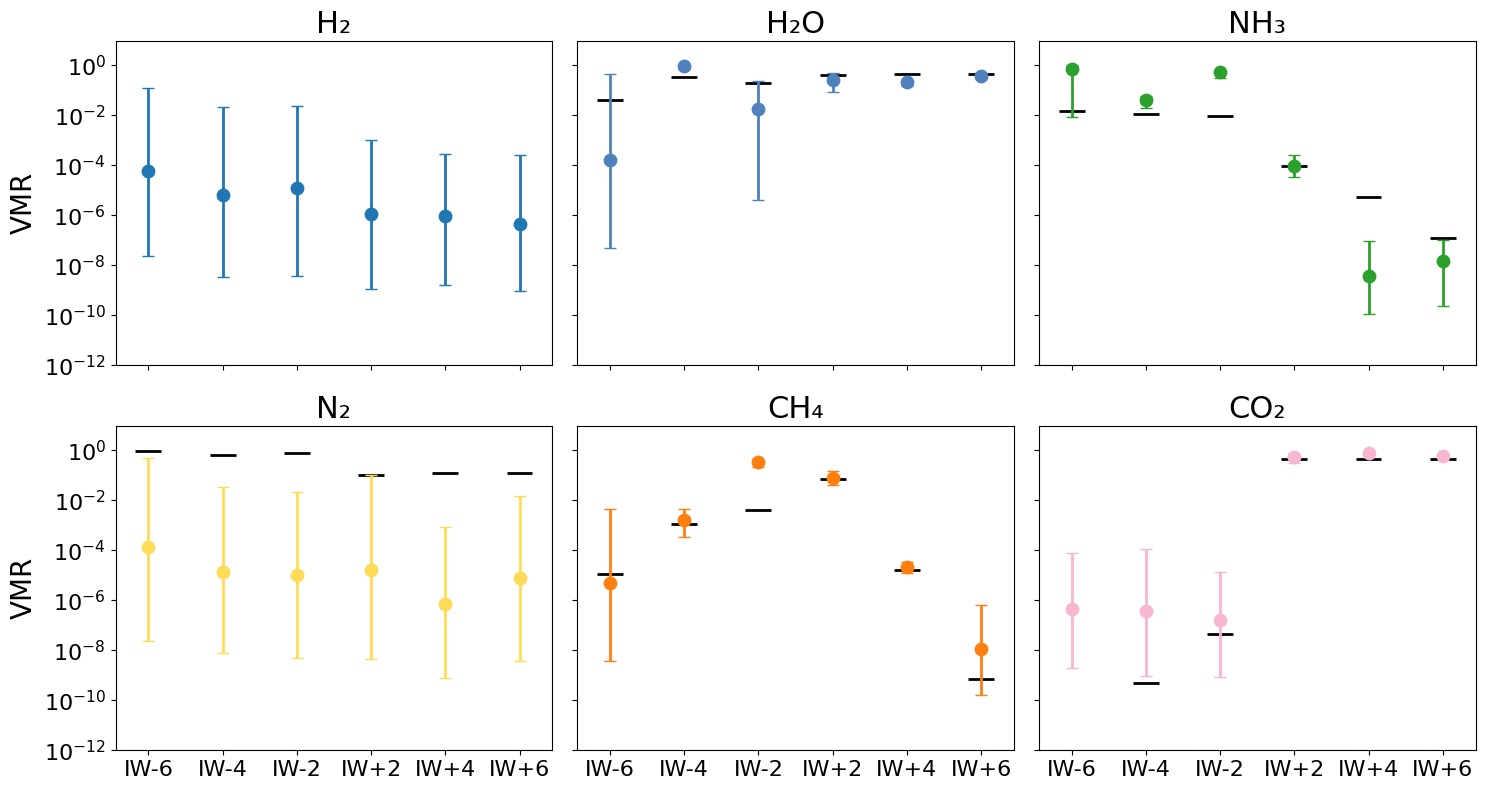

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
IW = np.loadtxt('Figure2/Figure2_buffer.csv', delimiter=',')  # x-axis (IW values)
T_surf = np.loadtxt('Figure2/Figure2_T_surf.csv', delimiter=',')  # y-axis (T values)
pressure_overall = np.loadtxt('Figure2/Figure2_P_atm.csv', delimiter=',')

pressure_H2 = noack_files('Figure2_P_H2.csv')
pressure_H2O = noack_files('Figure2_P_H2O.csv')
pressure_NH3 = noack_files('Figure2_P_NH3.csv')
pressure_N2 = noack_files('Figure2_P_N2.csv')
pressure_CH4 = noack_files('Figure2_P_CH4.csv')
pressure_CO2 = noack_files('Figure2_P_CO2.csv')

pressures = np.stack([pressure_H2, pressure_H2O, pressure_NH3, 
                      pressure_N2, pressure_CH4, pressure_CO2], axis=-1)

labels_all = ['H₂', 'H₂O', 'NH₃', 'N₂', 'CH₄', 'CO₂']
colors_all = ["#1f77b4", "#4f81bd", "#2ca02c", "#ffdb58", "#ff7f0e", "#f7b6d2"]

IW_print_values = [iw for iw in np.arange(-6, 7, 2) if iw != 0]
T = 600  # fixed temperature

ij_indices = {}
for IW_print in IW_print_values:
    for i, iw in enumerate(IW):
        for j, temp in enumerate(T_surf):
            if round(iw, 0) == IW_print and round(temp, 0) == T:
                ij_indices[IW_print] = (j, i)
                break

fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

for mol_index, (label, color) in enumerate(zip(labels_all, colors_all)):
    observed_vals = []
    retrieved_vals = []
    retrieved_errs = []  # store 1σ uncertainties

    x_labels = []
    
    for IW_print in IW_print_values:
        if IW_print not in ij_indices:
            continue

        j, i = ij_indices[IW_print]
        if IW_print >0:
            x_labels.append(f"IW+{IW_print}")
        else:
            x_labels.append(f"IW{IW_print}")

        #forward model
        fractions_data = pressures[j, i, :]
        total_pressure = np.sum(fractions_data)
        observed_rel = fractions_data[mol_index] / total_pressure
        observed_vals.append(observed_rel)

        #retrieved
        directory = f"NO_S_{IW_print}_{T}"
        data = limits_function(f"{directory}/pew_output.dat")

        # Extract log10 partial pressure arrays for each species
        H2_dist  = 10**data[1][:]
        H2O_dist = 10**data[2][:]
        NH3_dist = 10**data[5][:]
        N2_dist  = 10**data[6][:]
        CH4_dist = 10**data[4][:]
        CO2_dist = 10**data[3][:]

        posterior_pp = np.vstack([H2_dist, H2O_dist, NH3_dist, 
                                  N2_dist, CH4_dist, CO2_dist]).T

        total_pp_samples = np.sum(posterior_pp, axis=1)
        
        vmr_dist = posterior_pp[:, mol_index] / total_pp_samples

        # Median + 1 sigma of vmr
        vmr_med = np.median(vmr_dist)
        vmr_lo  = np.percentile(vmr_dist, 16)
        vmr_hi  = np.percentile(vmr_dist, 84)

        retrieved_vals.append(vmr_med)
        retrieved_errs.append([vmr_med - vmr_lo, vmr_hi - vmr_med])

    retrieved_errs = np.array(retrieved_errs).T
    x = np.arange(len(x_labels))
    bar_width = 0.35

    row = mol_index // 3
    col = mol_index % 3
    ax = axs[row, col]

    # True values
    ax.hlines(observed_vals, x - bar_width/2, x + bar_width/2,
              colors='black', linewidth=2)

    # Retrieved median values
    ax.scatter(x, retrieved_vals, color=color, s=80, zorder=4)

    # Error bars (1σ)
    ax.errorbar(
        x, retrieved_vals,
        yerr=retrieved_errs,
        fmt='none',
        ecolor=color,
        elinewidth=2,
        capsize=4,
        zorder=5
    )

    if row == 1:
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, fontsize=13)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels([])

    if col == 0:
        ax.set_ylabel('VMR', fontsize=20)
    else:
        ax.set_yticklabels([])

    ax.set_yscale('log'); ax.set_ylim(1e-12,9)
    ax.set_title(f"{label}", fontsize=22)
    ax.tick_params(axis='both', labelsize=16)
    ax.axhline(1e-12, c='black', linestyle='--', linewidth=0.75)


plt.tight_layout()
plt.savefig("Images/bar_all_molecules.pdf", format='pdf')
plt.show()


## Figure 4|

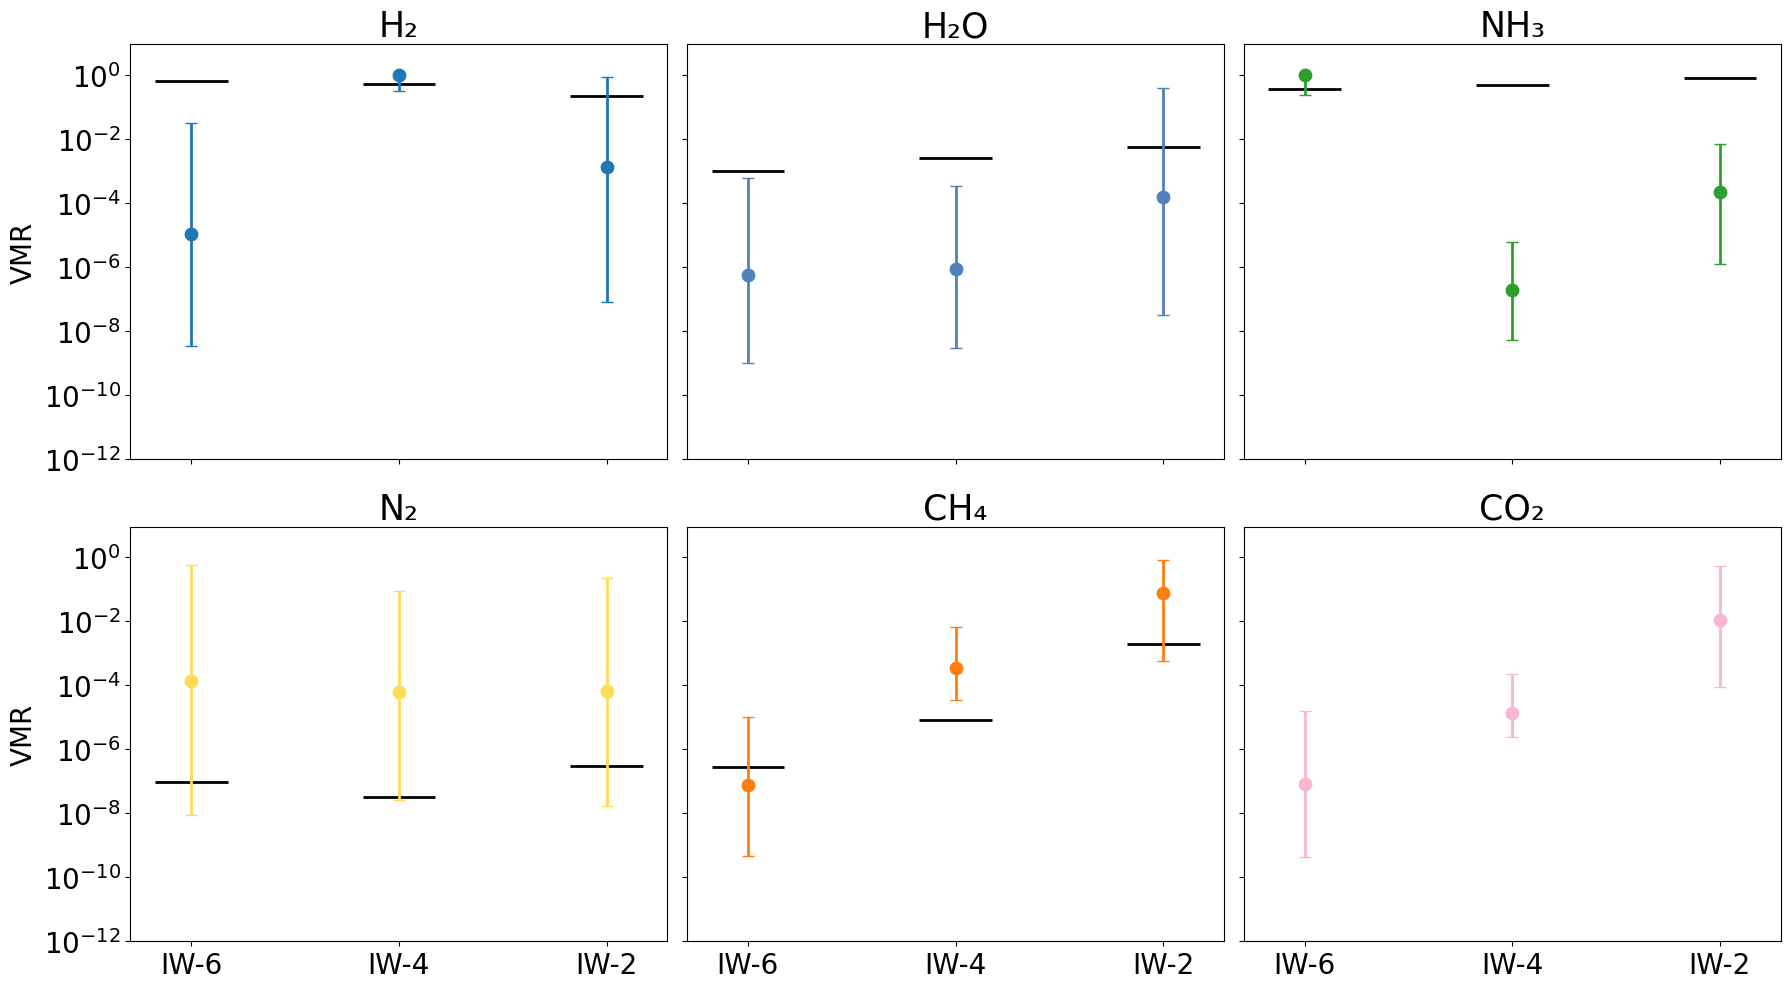

In [13]:
import numpy as np
import matplotlib.pyplot as plt

IW = np.loadtxt('Figure3/Figure3_buffer.csv', delimiter=',')
pressure_overall = np.loadtxt('Figure3/Figure3_P_atm.csv', delimiter=',')

pressure_H2 = noack_files_3('Figure3_P_H2.csv')
pressure_H2O = noack_files_3('Figure3_P_H2O.csv')
pressure_NH3 = noack_files_3('Figure3_P_NH3.csv')
pressure_N2 = noack_files_3('Figure3_P_N2.csv')
pressure_CH4 = noack_files_3('Figure3_P_CH4.csv')
pressure_CO2 = noack_files_3('Figure3_P_CO2.csv')

pressures = np.stack([pressure_H2, pressure_H2O, pressure_NH3, 
                      pressure_N2, pressure_CH4, pressure_CO2], axis=-1)

labels_all = ['H₂', 'H₂O', 'NH₃', 'N₂', 'CH₄', 'CO₂']
colors_all = ["#1f77b4", "#4f81bd", "#2ca02c", "#ffdb58", "#ff7f0e", "#f7b6d2"]

iw_values = [-6, -4, -2]
T = 300

ij_indices = {}
for IW_print in iw_values:
    for i, iw in enumerate(IW):
        if round(iw, 0) == IW_print:
            ij_indices[IW_print] = i
            break

fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharey='row')

for mol_index, (label, color) in enumerate(zip(labels_all, colors_all)):
    row = mol_index // 3
    col = mol_index % 3
    ax = axs[row, col]

    observed_vals = []
    retrieved_med = []
    retrieved_errs = []

    for IW_print in iw_values:
        i = ij_indices[IW_print]

        fractions_data = pressures[-1, i, :]
        total_pressure = np.sum(fractions_data)
        observed_rel = fractions_data[mol_index] / total_pressure
        observed_vals.append(observed_rel)

        directory = f"NO_S_{IW_print}_{T}"
        data = limits_function(f"{directory}/pew_output.dat")

        H2_dist  = 10**data[1][:]
        H2O_dist = 10**data[2][:]
        NH3_dist = 10**data[5][:]
        N2_dist  = 10**data[6][:]
        CH4_dist = 10**data[4][:]
        CO2_dist = 10**data[3][:]

        posterior_pp = np.vstack([
            H2_dist, H2O_dist, NH3_dist,
            N2_dist, CH4_dist, CO2_dist
        ]).T

        total_pp_samples = np.sum(posterior_pp, axis=1)
        vmr_dist = posterior_pp[:, mol_index] / total_pp_samples

        vmr_med = np.median(vmr_dist)
        vmr_lo  = np.percentile(vmr_dist, 16)
        vmr_hi  = np.percentile(vmr_dist, 84)

        retrieved_med.append(vmr_med)
        retrieved_errs.append([vmr_med - vmr_lo, vmr_hi - vmr_med])

    retrieved_errs = np.array(retrieved_errs).T
    x = np.arange(len(iw_values))
    bar_width = 0.35

    ax.hlines(observed_vals, x - bar_width/2, x + bar_width/2,
              colors='black', linewidth=2)

    ax.scatter(x, retrieved_med, color=color, s=80, zorder=4)

    ax.errorbar(
        x, retrieved_med,
        yerr=retrieved_errs,
        fmt='none',
        ecolor=color,
        elinewidth=2,
        capsize=4,
        zorder=5
    )

    ax.set_yscale('log'); ax.set_ylim(1e-12,9)
    ax.set_title(label, fontsize=25)
    ax.set_xticks(x)
    if row == 1:
        ax.set_xticklabels([f"IW{val}" for val in iw_values], fontsize=20)
    else:
        ax.set_xticklabels([])
    if col == 0:
        ax.set_ylabel('VMR', fontsize=20)

    ax.tick_params(axis='both', labelsize=20)
    ax.axhline(1e-12, c='black', linestyle='--', linewidth=0.75)

plt.tight_layout()
plt.savefig("Images/bar_frac_6molecules_IW_-6_-4_-2.pdf", format='pdf')
plt.show()

# Figure 5

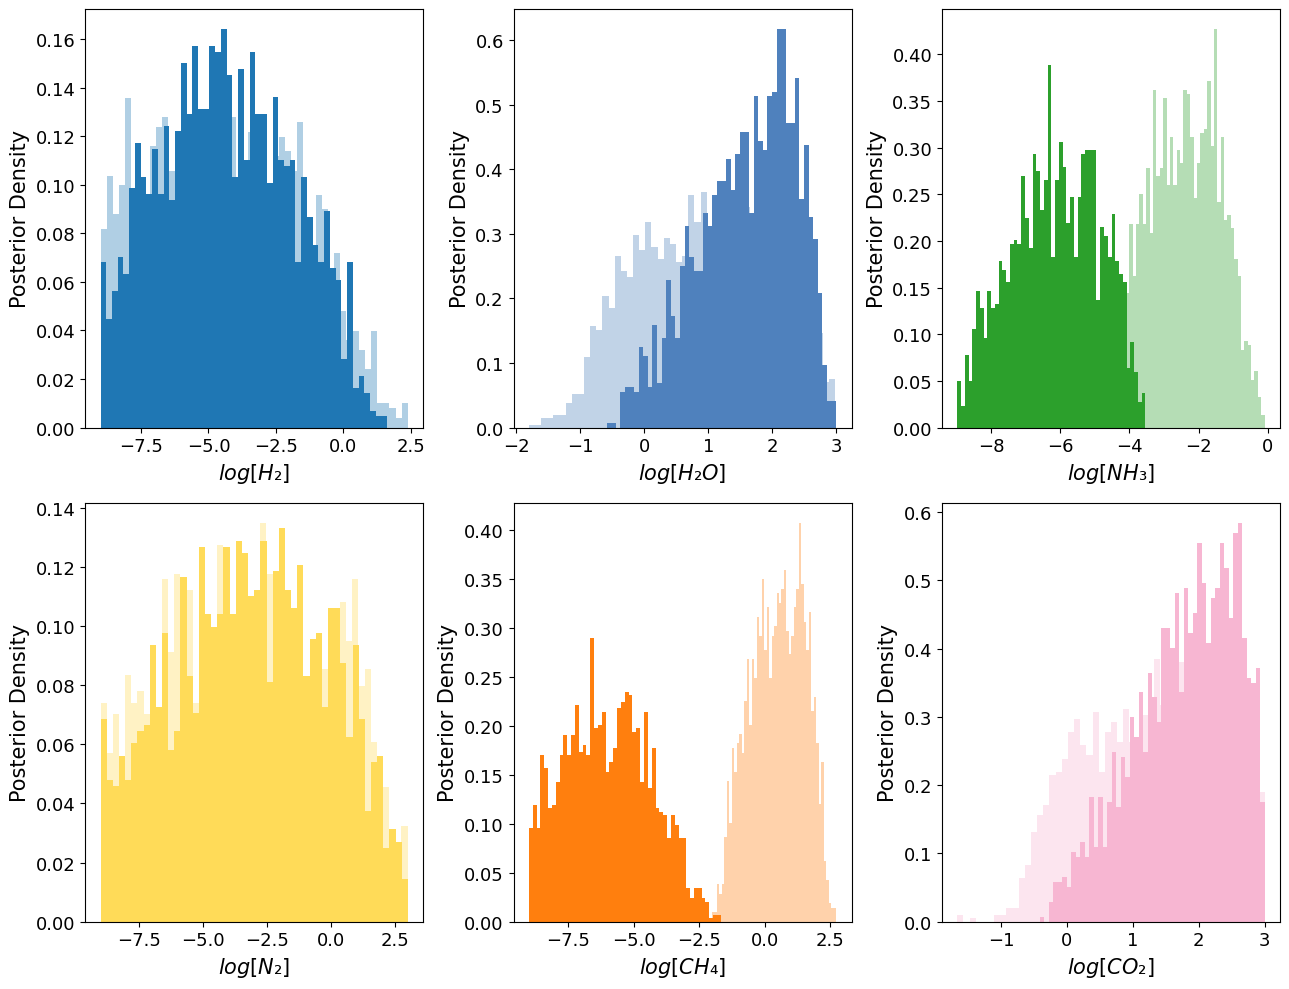

In [18]:
from matplotlib.pyplot import figure, show

#which IW to check
IW_a = 6
IW_b = 2

IW = np.loadtxt('Figure2/Figure2_buffer.csv', delimiter=',')  # x-axis (IW values)
T_surf = np.loadtxt('Figure2/Figure2_T_surf.csv', delimiter=',')  # y-axis (T values)
pressure_overall = np.loadtxt('Figure2/Figure2_P_atm.csv', delimiter=',')

pressure_H2 = noack_files('Figure2_P_H2.csv')
pressure_H2O = noack_files('Figure2_P_H2O.csv')
pressure_NH3 = noack_files('Figure2_P_NH3.csv')
pressure_N2 = noack_files('Figure2_P_N2.csv')
pressure_CH4 = noack_files('Figure2_P_CH4.csv')
pressure_CO2 = noack_files('Figure2_P_CO2.csv')

#shape: num_T x num_IW x 6 molecules
pressures = np.stack([pressure_H2, pressure_H2O, pressure_NH3, 
                      pressure_N2, pressure_CH4, pressure_CO2], axis=-1)

data_a = posterior_distributions(f"NO_S_{IW_a}_600/pew_output.dat")
data_b = posterior_distributions(f"NO_S_{IW_b}_600/pew_output.dat")

#draw all posterior distributions
for n in ['a','b']:
    locals()[f"H2_{n}"] = locals()[f"data_{n}"][1][:]
    locals()[f"H2O_{n}"] = locals()[f"data_{n}"][2][:]
    locals()[f"CO2_{n}"] = locals()[f"data_{n}"][3][:]
    locals()[f"CH4_{n}"] = locals()[f"data_{n}"][4][:]
    locals()[f"NH3_{n}"] = locals()[f"data_{n}"][5][:]
    locals()[f"N2_{n}"] = locals()[f"data_{n}"][6][:]

fig = figure(figsize=(13,10))

molecules = ["H2", "H2O", "NH3", "N2","CH4", "CO2"]
labels_all = ['H₂', 'H₂O', 'NH₃', 'N₂', 'CH₄', 'CO₂']

colors = ["#1f77b4","#4f81bd","#2ca02c","#ffdb58","#ff7f0e","#f7b6d2"]

for n in range(6):
    frame = fig.add_subplot(2, 3, n + 1)
    frame.hist(locals()[f"{molecules[n]}_a"], density=True, bins=50,color=colors[n],label=f"IW{IW_a}")
    frame.hist(locals()[f"{molecules[n]}_b"], density=True, bins=50,color=colors[n],alpha=.35,label=f"IW{IW_b}")
    frame.set_xlabel(fr"$log[{labels_all[n]}]$",fontsize=15); frame.set_ylabel("Posterior Density",fontsize=15)
    
    median_a = np.median(locals()[f"{molecules[n]}_a"])
    median_b = np.median(locals()[f"{molecules[n]}_b"])
    
    
    #median vertical lines
    #frame.axvline(median_a, color='black', label="Median of Distribution",linestyle=':')
    #frame.axvline(median_b, color='black',alpha=.35,linestyle=':')
    
    #real values
    
    #IW and Temperature to print out:
    IWs = [IW_a,IW_b]

    for i, iw in enumerate(IW):
        for j, temp in enumerate(T_surf):
            fractions = pressures[j, i, :]
            total_pressure = np.sum(fractions)
            if (round(iw, 0) == IWs[0] or round(iw, 0) == IWs[1]) and round(temp, 0) == 600:
                #print("Overall Pressure: ", total_pressure)
                H2 = fractions[0]
                H2O = fractions[1] 
                NH3 = fractions[2] 
                N2 = fractions[3] 
                CH4 = fractions[4] 
                CO2 = fractions[5] 
                    

    #frame.legend()
    frame.tick_params(axis='both', labelsize=13)

    
plt.tight_layout()
plt.savefig(f"Images/abundances_posteriors_{IW_a}-{IW_b}.pdf",format='pdf')    
show()

# Figure 6

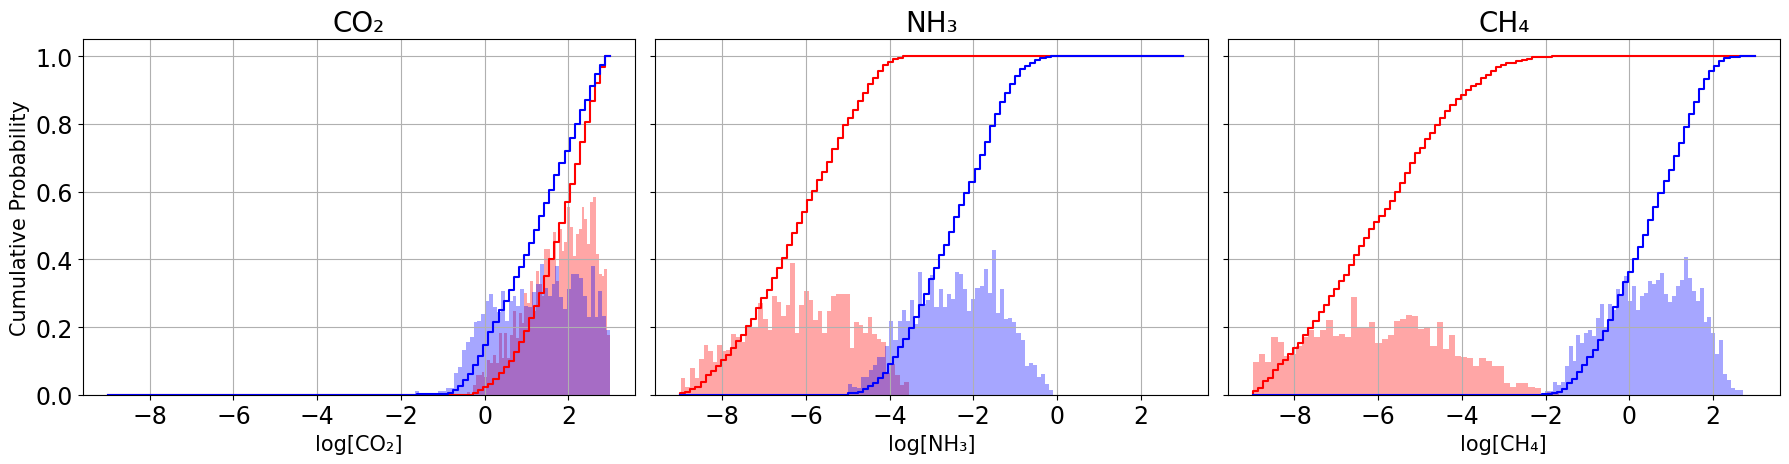

Delta_CO2 = 0.22833755885548718
Delta_NH3 = 0.9100561390800435
Delta_CH4 = 0.9975099601593626


In [20]:
# Which IW to check
IW_a = 6
IW_b = 2

molecules = ['CO2', 'NH3', 'CH4']
labels_all = ['CO₂','NH₃', 'CH₄']

# Load data
data_a = posterior_distributions(f"NO_S_{IW_a}_600/pew_output.dat")
data_b = posterior_distributions(f"NO_S_{IW_b}_600/pew_output.dat")

# Draw all posterior distributions
for n in ['a', 'b']:
    locals()[f"H2_{n}"] = locals()[f"data_{n}"][1][:]
    locals()[f"H2O_{n}"] = locals()[f"data_{n}"][2][:]
    locals()[f"CO2_{n}"] = locals()[f"data_{n}"][3][:]
    locals()[f"CH4_{n}"] = locals()[f"data_{n}"][4][:]
    locals()[f"NH3_{n}"] = locals()[f"data_{n}"][5][:]
    locals()[f"N2_{n}"] = locals()[f"data_{n}"][6][:]

priormin = -9
priormax = 3

def empirical_cdf_over_prior(posterior_samples, prior_min=-9, prior_max=3, num_points=100):
    x = np.linspace(prior_min, prior_max, num_points)
    cdf = np.array([np.sum(posterior_samples <= val) / len(posterior_samples) for val in x])
    return x, cdf

# Compute all empirical CDFs
for n in ['a', 'b']:
    x, locals()[f"cumulative_H2_{n}"] = empirical_cdf_over_prior(locals()[f"H2_{n}"])
    x, locals()[f"cumulative_H2O_{n}"] = empirical_cdf_over_prior(locals()[f"H2O_{n}"])
    x, locals()[f"cumulative_CO2_{n}"] = empirical_cdf_over_prior(locals()[f"CO2_{n}"])
    x, locals()[f"cumulative_CH4_{n}"] = empirical_cdf_over_prior(locals()[f"CH4_{n}"])
    x, locals()[f"cumulative_NH3_{n}"] = empirical_cdf_over_prior(locals()[f"NH3_{n}"])
    x, locals()[f"cumulative_N2_{n}"] = empirical_cdf_over_prior(locals()[f"N2_{n}"])

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, molecule in enumerate(molecules):
    ax = axes[i]
    ax.step(x, locals()[f"cumulative_{molecule}_a"], color='red', label=f"IW: {IW_a}")
    ax.hist(locals()[f"{molecule}_a"], alpha=.35, density=True, color='red', bins=50)
    ax.step(x, locals()[f"cumulative_{molecule}_b"], color='blue', label=f"IW: {IW_b}")
    ax.hist(locals()[f"{molecule}_b"], alpha=.35, density=True, color='blue', bins=50)

    locals()[f"Delta_{molecule}"] = np.max(abs(locals()[f"cumulative_{molecule}_a"] - locals()[f"cumulative_{molecule}_b"]))

    ax.set_title(f'{labels_all[i]}',fontsize=20)
    ax.set_xlabel(f"log[{labels_all[i]}]",fontsize=15)
    ax.grid(True)
    if i == 0:
        ax.set_ylabel('Cumulative Probability',fontsize=15)
    #ax.legend(fontsize=15)
    ax.tick_params(axis='both', labelsize=17) 


#plt.suptitle(f'Empirical CDF Comparison at IW {IW_a} vs IW {IW_b}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"Images/CDF-comparison_{IW_a}-{IW_b}_rowplot.pdf", format='pdf')
plt.show()

# Print the Delta values
for molecule in molecules:
    print(f"Delta_{molecule} =", locals()[f"Delta_{molecule}"])



# Figure 7

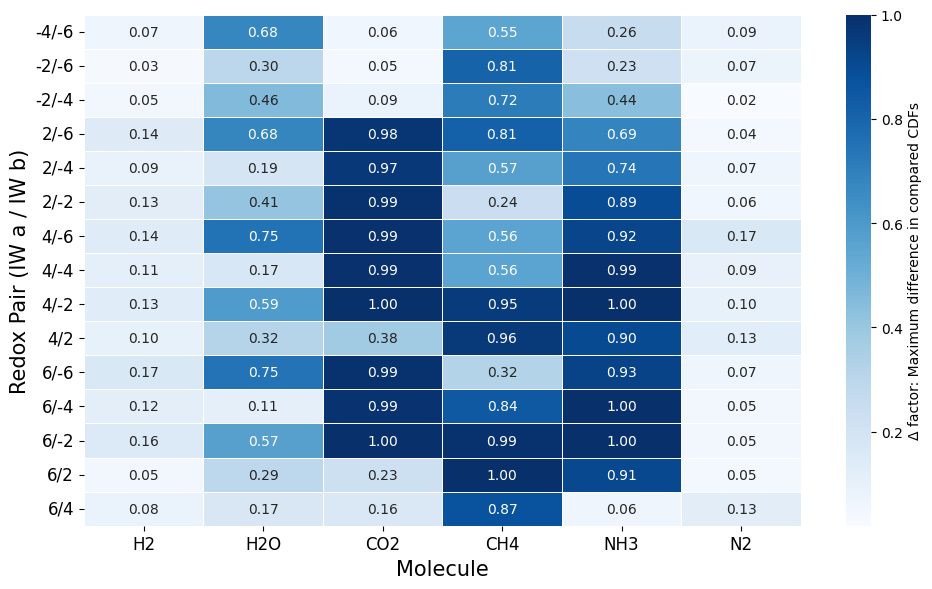

In [20]:
redox_states = [6, 4, 2, -2, -4, -6]
redox_states = redox_states[::-1]
priormin = -9
priormax = 3

def empirical_cdf_over_prior(posterior_samples, prior_min=-9, prior_max=3, num_points=100):
    x = np.linspace(prior_min, prior_max, num_points)
    cdf = np.array([np.sum(posterior_samples <= val) / len(posterior_samples) for val in x])
    return x, cdf


rows = []
molecules = ['H2', 'H2O', 'CO2', 'CH4', 'NH3', 'N2']

grid = [[(i, j) for j in redox_states] for i in redox_states]

for i in range(len(redox_states)):
    for j in range(len(redox_states)):
        IW_a, IW_b = grid[i][j]
        
        if IW_a == IW_b:
            break
        
        #posterior data
        data_a = posterior_distributions(f"NO_S_{IW_a}_600/pew_output.dat")
        data_b = posterior_distributions(f"NO_S_{IW_b}_600/pew_output.dat")

        deltas = {}
        for idx, mol in zip(range(1, 7), molecules):
            a_samples = data_a[idx]
            b_samples = data_b[idx]

            _, cdf_a = empirical_cdf_over_prior(a_samples)

            _, cdf_b = empirical_cdf_over_prior(b_samples)

            delta = np.max(np.abs(cdf_a - cdf_b))
            deltas[mol] = delta * 100  # convert to percentage

        row_label = f"{IW_a}/{IW_b}"
        deltas['Redox Pair'] = row_label
        rows.append(deltas)

# Create the dataframe
df = pd.DataFrame(rows)
df.set_index("Redox Pair", inplace=True)

# Display heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df/100, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Δ factor: Maximum difference in compared CDFs'})
#plt.title("Delta [%] Between Redox State Pairs for Each Molecule")
plt.ylabel("Redox Pair (IW a / IW b)",fontsize=15)
plt.xlabel("Molecule",fontsize=15)
plt.tick_params(axis='both', labelsize=12)  # Change 12 to any desired font size
plt.tight_layout()
plt.savefig(f"Images/grid-comparison_{IW_a}-{IW_b}.pdf",format='pdf')
plt.show()

# Corner Plots

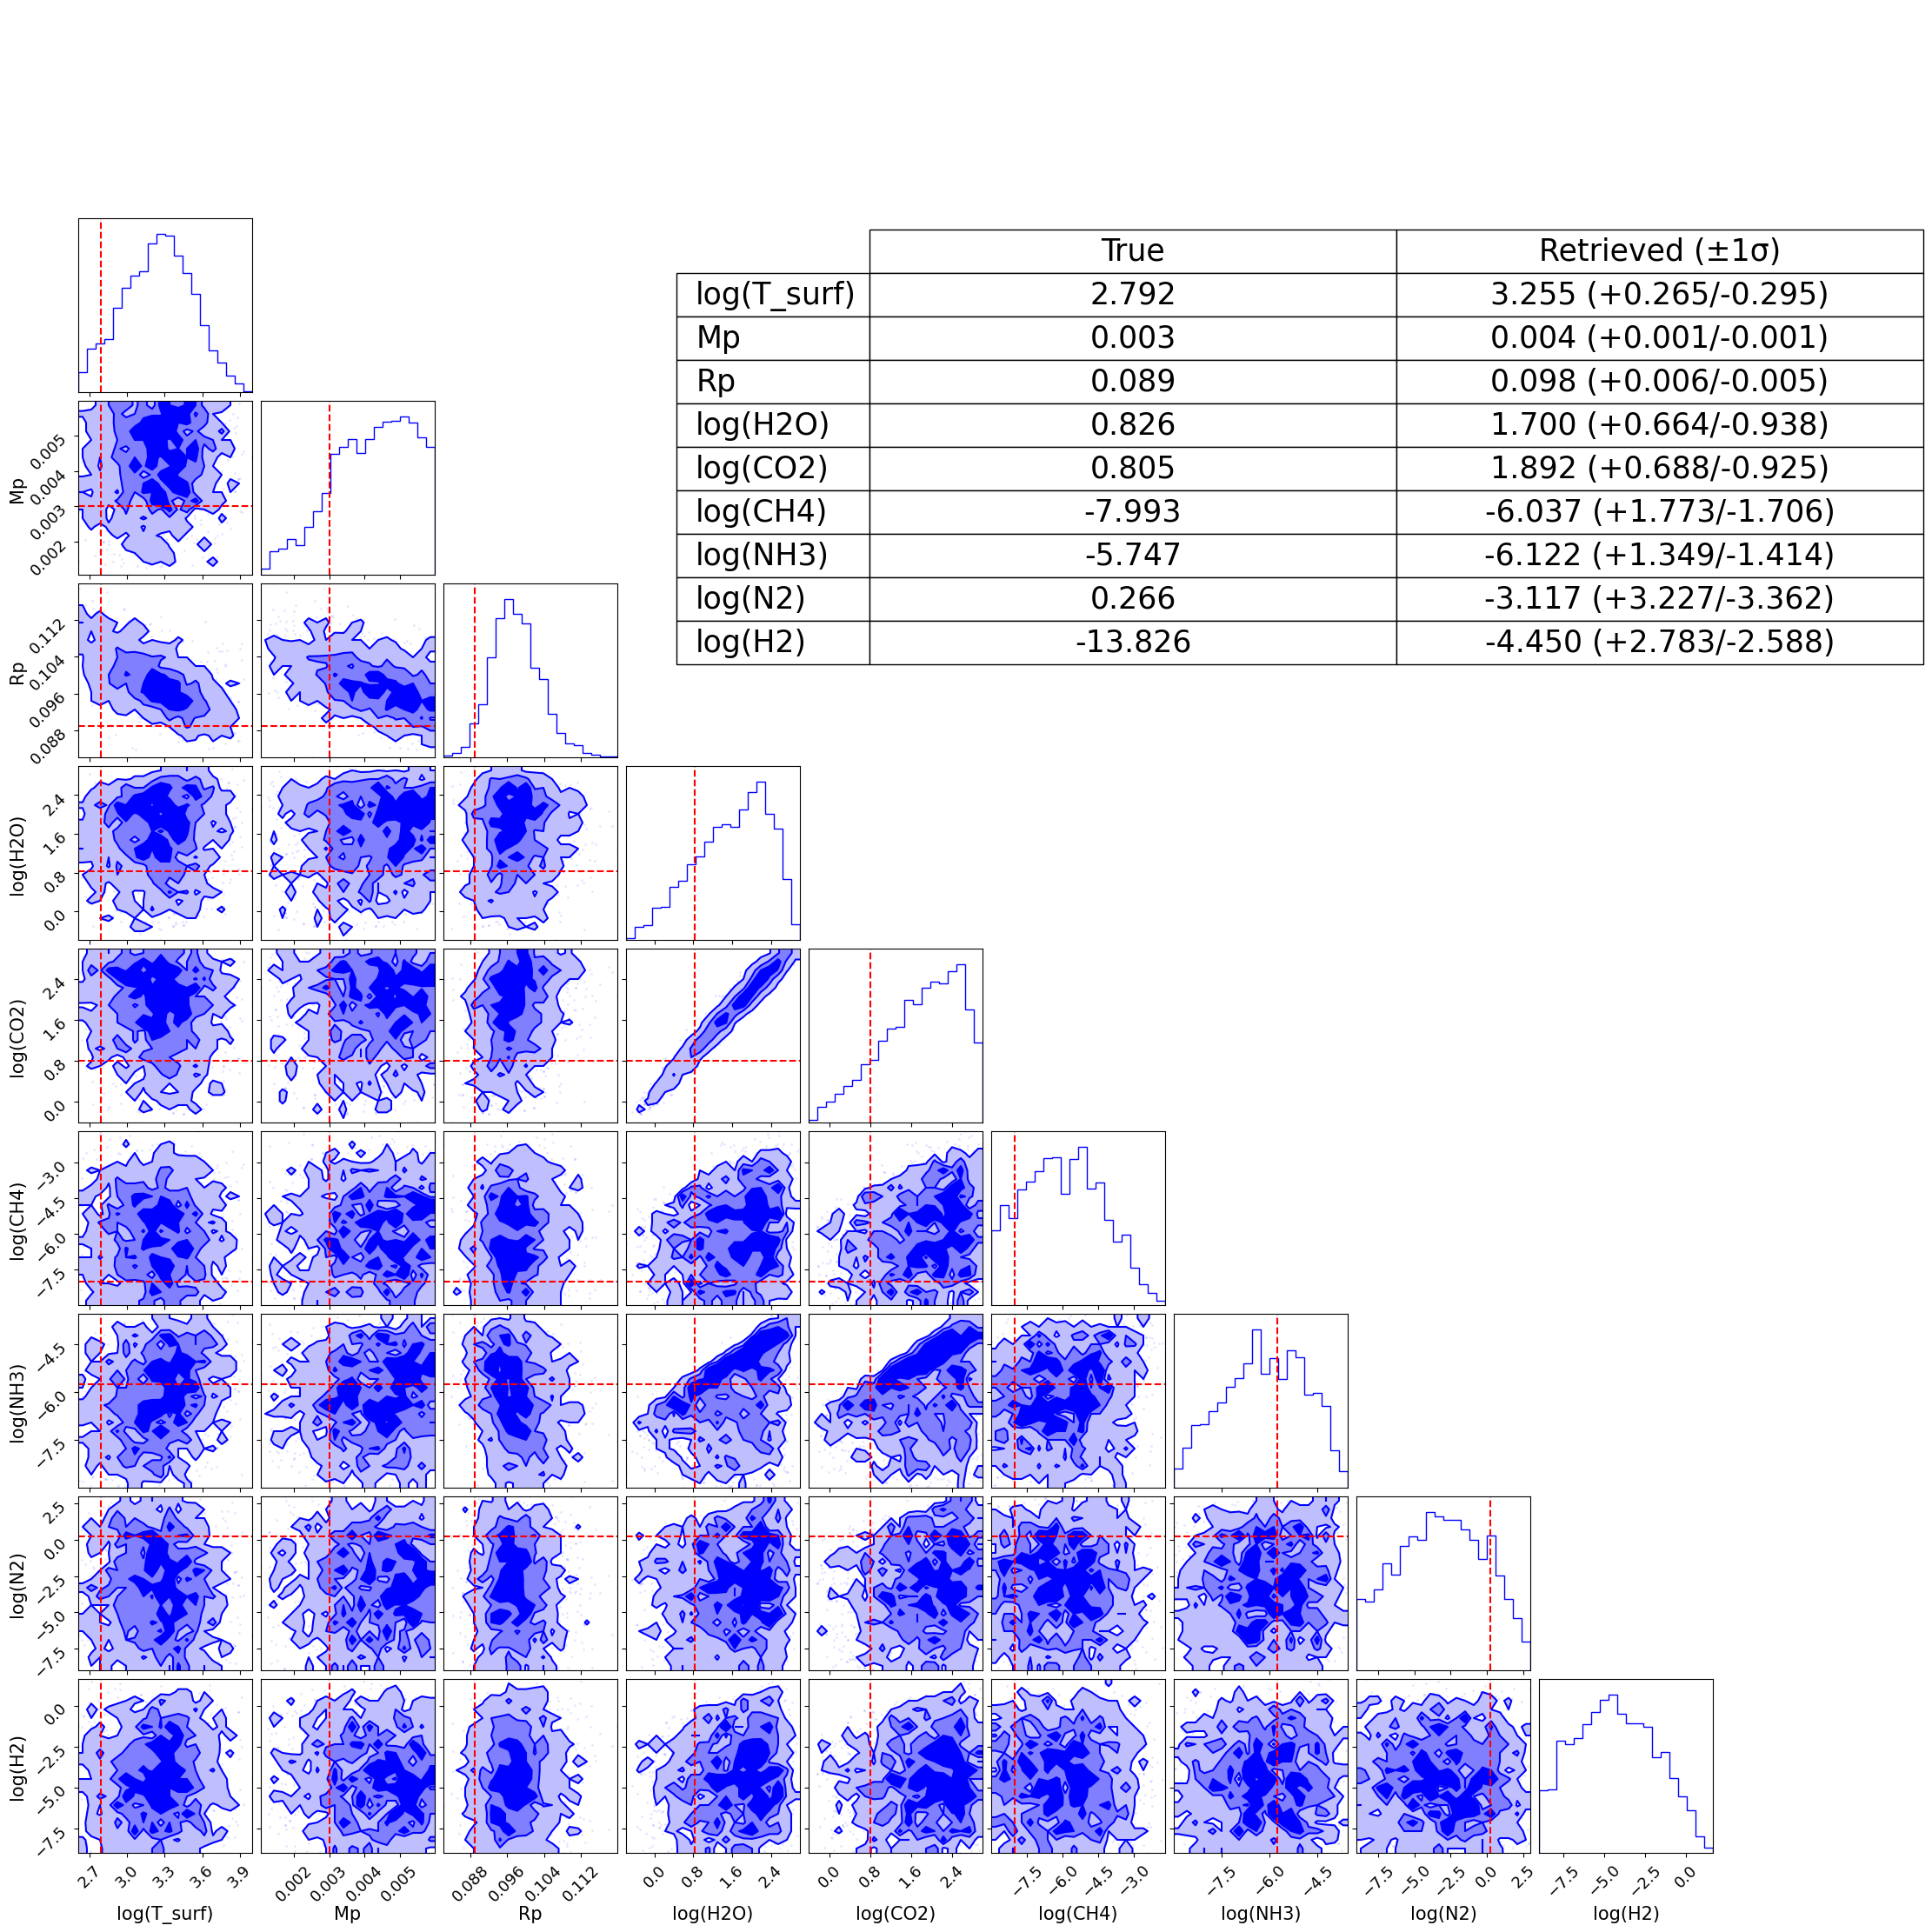

In [19]:
warnings.simplefilter('ignore')

directory = "NO_S_6_600"
data = posterior_distributions(f"{directory}/pew_output.dat")

H2 = data[1][:]
H2O = data[2][:]
CO2 = data[3][:]
CH4 = data[4][:]
NH3 = data[5][:]
N2 = data[6][:]
Rp = data[7][:]
Mp = data[8][:]
T_eff = data[21][:]
T_surf = data[14][:]

molecules = np.vstack([H2, H2O, CO2, CH4, NH3, N2]).T
H2_norm, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm = molecules.T

data = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
data_matrix = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
labels = ["log(T_surf)", "Mp", "Rp", "log(H2O)", "log(CO2)", "log(CH4)", "log(NH3)", "log(N2)", "log(H2)"]

temperature, pressure, _ = read_dat_file_with_headers(f"Forward-Files/{directory}/mixingratios.dat")
surface_temperature = np.max(temperature)
maximum_pressure_forward = np.max(pressure)

real_values = {
    "log(T_surf)": np.log10(surface_temperature),
    "Mp": 0.003,
    "Rp": 0.089,
    "log(H2O)": np.log10(0.4488 * maximum_pressure_forward),
    "log(CO2)": np.log10(0.4275 * maximum_pressure_forward),
    "log(CH4)": np.log10(6.8e-10 * maximum_pressure_forward),
    "log(NH3)": np.log10(1.2e-7 * maximum_pressure_forward),
    "log(N2)": np.log10(0.1236 * maximum_pressure_forward),
    "log(H2)": np.log10(1e-15 * maximum_pressure_forward),
}

# Generate corner plot without titles
figure = corner.corner(data_matrix,
                       labels=labels,
                       label_kwargs = {'fontsize':15},
                       show_titles=False,
                       color='blue',
                       fill_contours=True,
                       levels=(0.34, 0.68, 0.95))

axes = np.array(figure.axes).reshape((len(labels), len(labels)))

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=13)


# Draw red lines at true values
for i in range(len(labels)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:
            ax.axvline(real_values[labels[i]], color='red', linestyle='--')
        else:
            ax.axvline(real_values[labels[j]], color='red', linestyle='--')
            ax.axhline(real_values[labels[i]], color='red', linestyle='--')

# Compute medians and 1σ uncertainties
table_data = []
for i, label in enumerate(labels):
    median = np.median(data_matrix[:, i])
    lower = np.percentile(data_matrix[:, i], 16)
    upper = np.percentile(data_matrix[:, i], 84)
    err_minus = median - lower
    err_plus = upper - median
    true_val = real_values[label]
    result_str = f"{median:.3f} (+{err_plus:.3f}/-{err_minus:.3f})"
    table_data.append([f"{true_val:.3f}", result_str])

# Add table
table_labels = ["Parameter", "True Value", "Retrieved ±1σ"]
column_labels = ["True", "Retrieved (±1σ)"]
row_labels = labels

table_ax = figure.add_axes([0.65, 0.6, 0.3, 0.5])  # [left, bottom, width, height]
table_ax.axis('off')
the_table = table_ax.table(cellText=table_data,
                           rowLabels=row_labels,
                           colLabels=column_labels,
                           cellLoc='center',
                           loc='center')
the_table.scale(2, 3)
the_table.auto_set_font_size(False)
the_table.set_fontsize(25)

plt.savefig(f"Images/corner_{directory}.pdf", format="pdf", bbox_inches="tight")

# IW+4

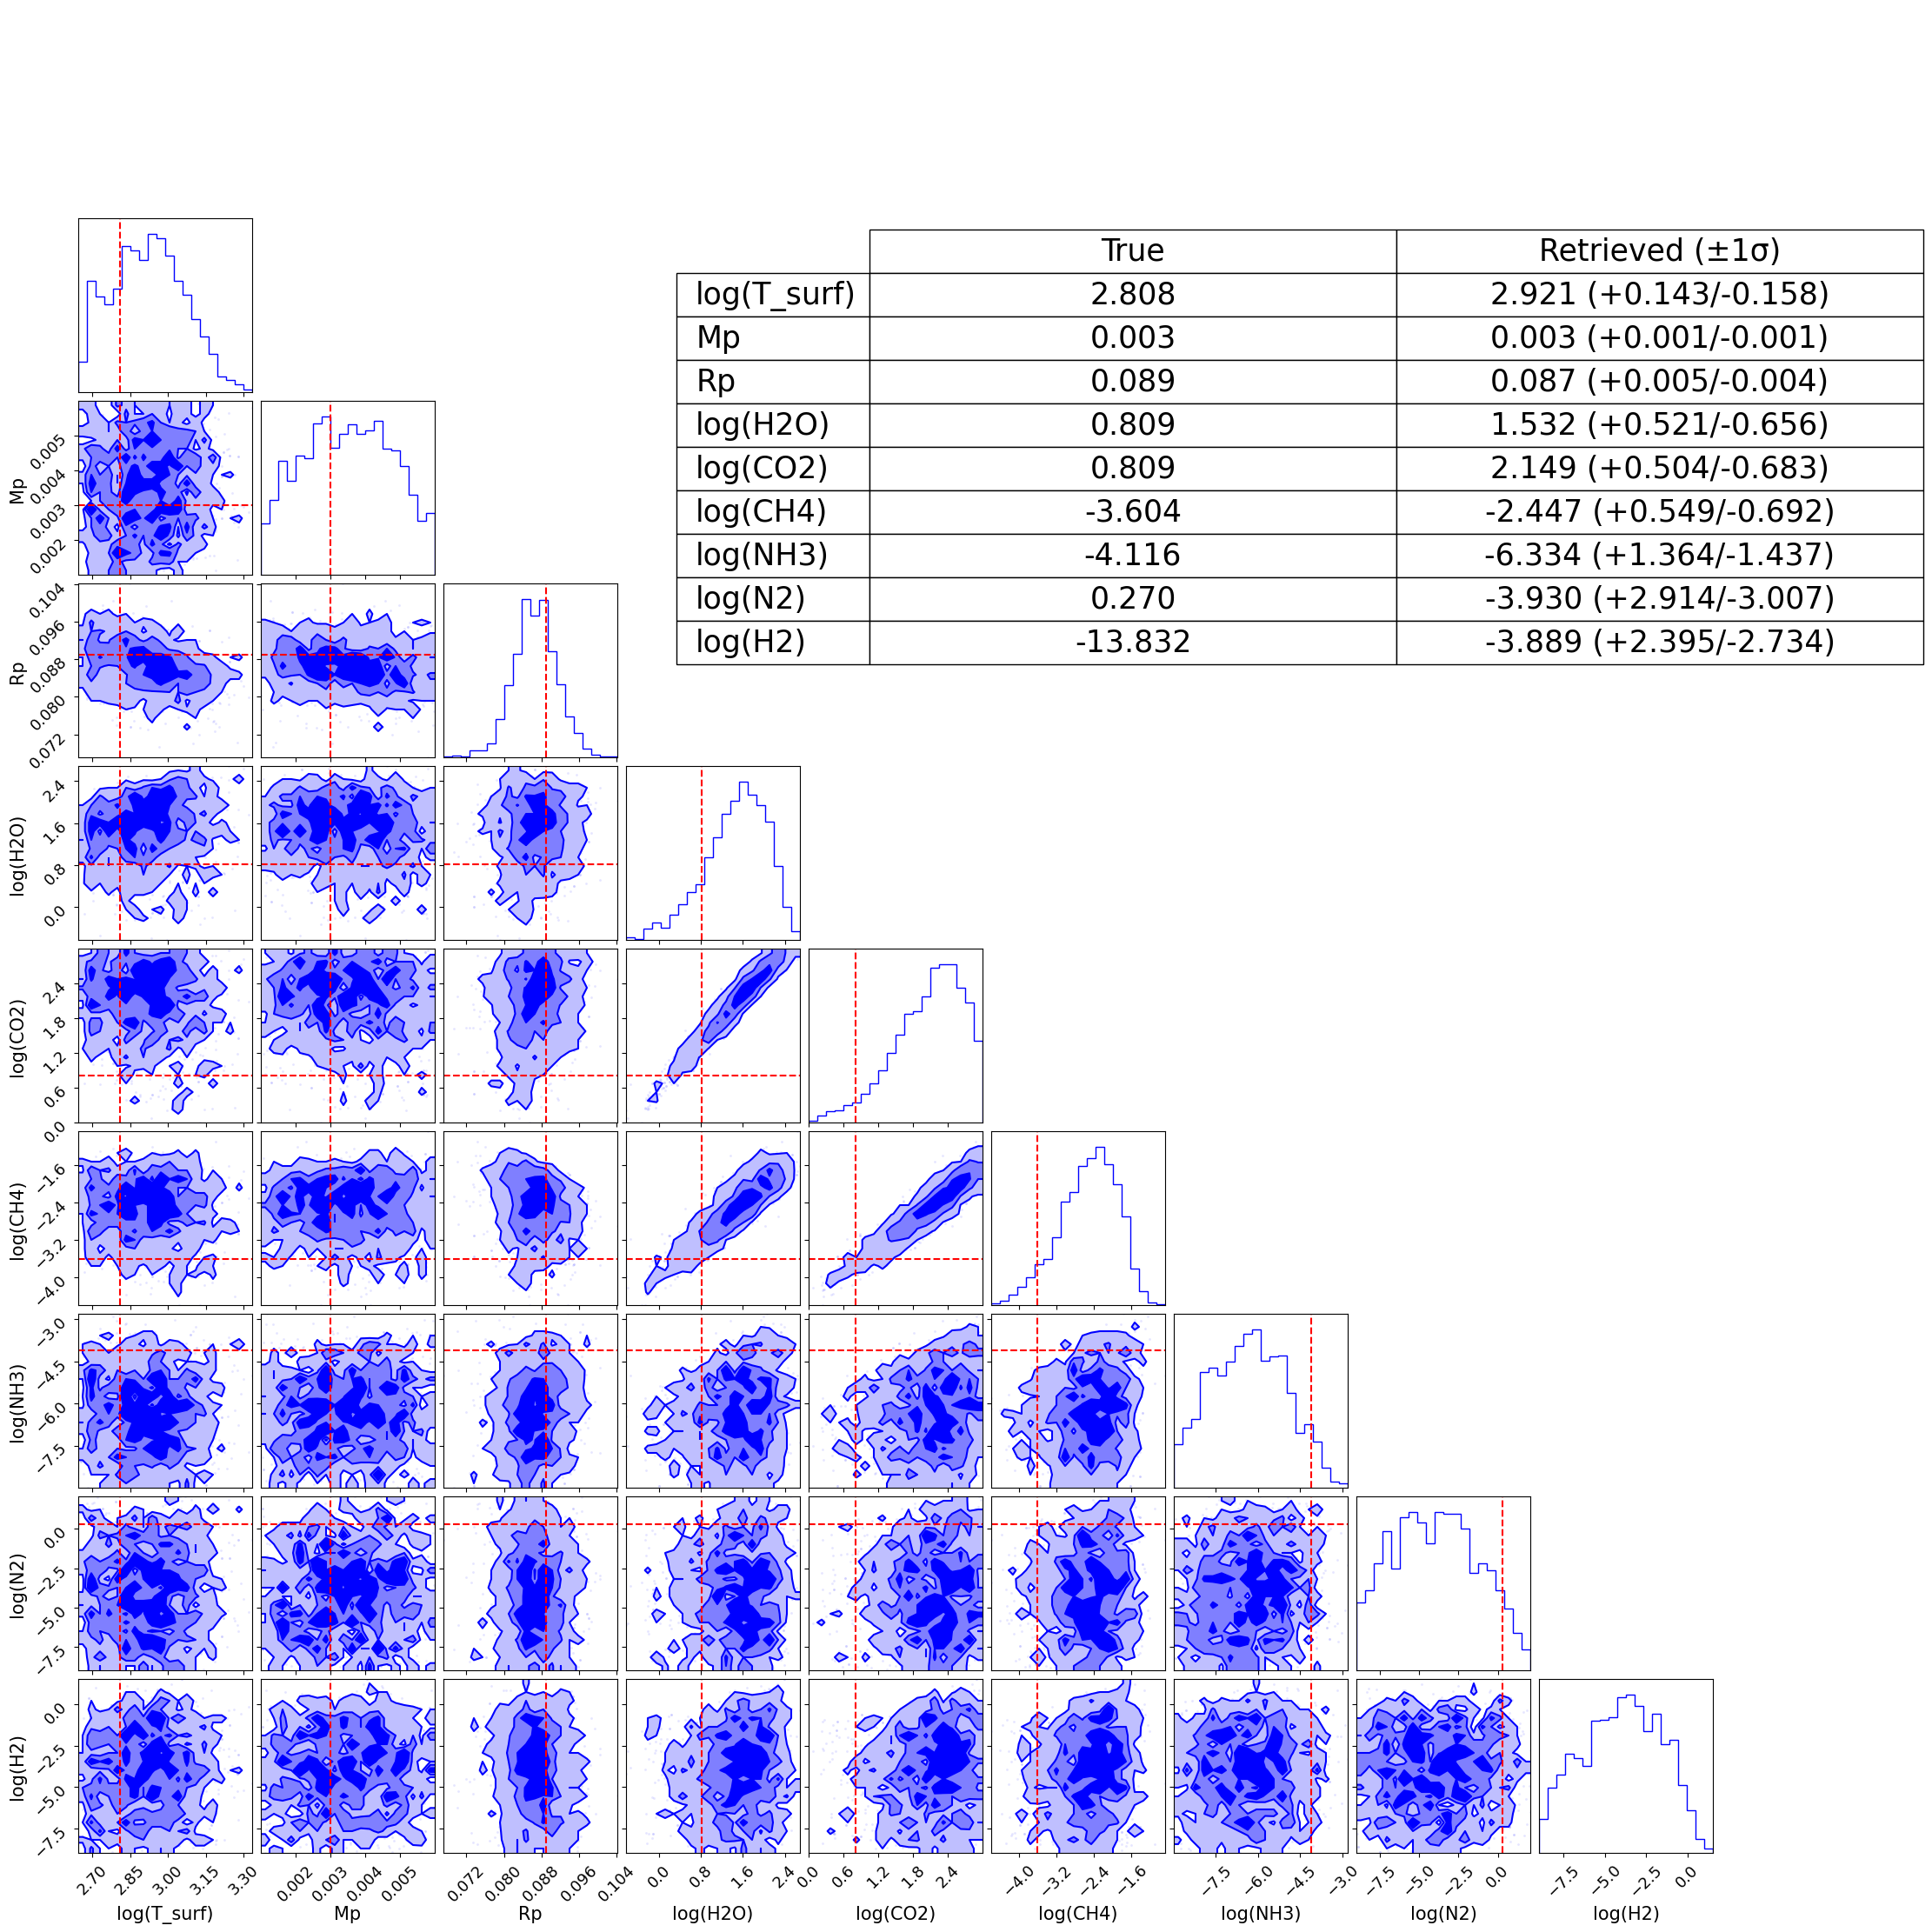

In [21]:
warnings.simplefilter('ignore')

directory = "NO_S_4_600"
data = posterior_distributions(f"{directory}/pew_output.dat")

H2 = data[1][:]
H2O = data[2][:]
CO2 = data[3][:]
CH4 = data[4][:]
NH3 = data[5][:]
N2 = data[6][:]
Rp = data[7][:]
Mp = data[8][:]
T_eff = data[21][:]
T_surf = data[14][:]

molecules = np.vstack([H2, H2O, CO2, CH4, NH3, N2]).T
H2_norm, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm = molecules.T

data = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
data_matrix = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
labels = ["log(T_surf)", "Mp", "Rp", "log(H2O)", "log(CO2)", "log(CH4)", "log(NH3)", "log(N2)", "log(H2)"]

temperature, pressure, _ = read_dat_file_with_headers(f"Forward-Files/{directory}/mixingratios.dat")
surface_temperature = np.max(temperature)
maximum_pressure_forward = np.max(pressure)

# Manually assigned real values
real_values = {
    "log(T_surf)":np.log10(surface_temperature),
    "Mp": 0.003,
    "Rp": 0.089,
    #"C/O": 0.333,
    "log(H2O)": np.log10(0.4369*maximum_pressure_forward),
    "log(CO2)": np.log10(0.4368*maximum_pressure_forward),
    "log(CH4)": np.log10(1.6880635366260494e-05*maximum_pressure_forward),
    "log(NH3)": np.log10(5.1942421622048494e-06*maximum_pressure_forward),
    "log(N2)": np.log10(0.1263*maximum_pressure_forward),
    "log(H2)": np.log10(1e-15*maximum_pressure_forward),
}

# Generate corner plot without titles
figure = corner.corner(data_matrix,
                       labels=labels,
                       label_kwargs = {'fontsize':15},
                       show_titles=False,
                       color='blue',
                       fill_contours=True,
                       levels=(0.34, 0.68, 0.95))

axes = np.array(figure.axes).reshape((len(labels), len(labels)))

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=13)


# Draw red lines at true values
for i in range(len(labels)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:
            ax.axvline(real_values[labels[i]], color='red', linestyle='--')
        else:
            ax.axvline(real_values[labels[j]], color='red', linestyle='--')
            ax.axhline(real_values[labels[i]], color='red', linestyle='--')

# Compute medians and 1σ uncertainties
table_data = []
for i, label in enumerate(labels):
    median = np.median(data_matrix[:, i])
    lower = np.percentile(data_matrix[:, i], 16)
    upper = np.percentile(data_matrix[:, i], 84)
    err_minus = median - lower
    err_plus = upper - median
    true_val = real_values[label]
    result_str = f"{median:.3f} (+{err_plus:.3f}/-{err_minus:.3f})"
    table_data.append([f"{true_val:.3f}", result_str])

# Add table
table_labels = ["Parameter", "True Value", "Retrieved ±1σ"]
column_labels = ["True", "Retrieved (±1σ)"]
row_labels = labels

table_ax = figure.add_axes([0.65, 0.6, 0.3, 0.5])  # [left, bottom, width, height]
table_ax.axis('off')
the_table = table_ax.table(cellText=table_data,
                           rowLabels=row_labels,
                           colLabels=column_labels,
                           cellLoc='center',
                           loc='center')
the_table.scale(2, 3)
the_table.auto_set_font_size(False)
the_table.set_fontsize(25)

plt.savefig(f"Images/corner_{directory}.pdf", format="pdf", bbox_inches="tight")


# IW+2

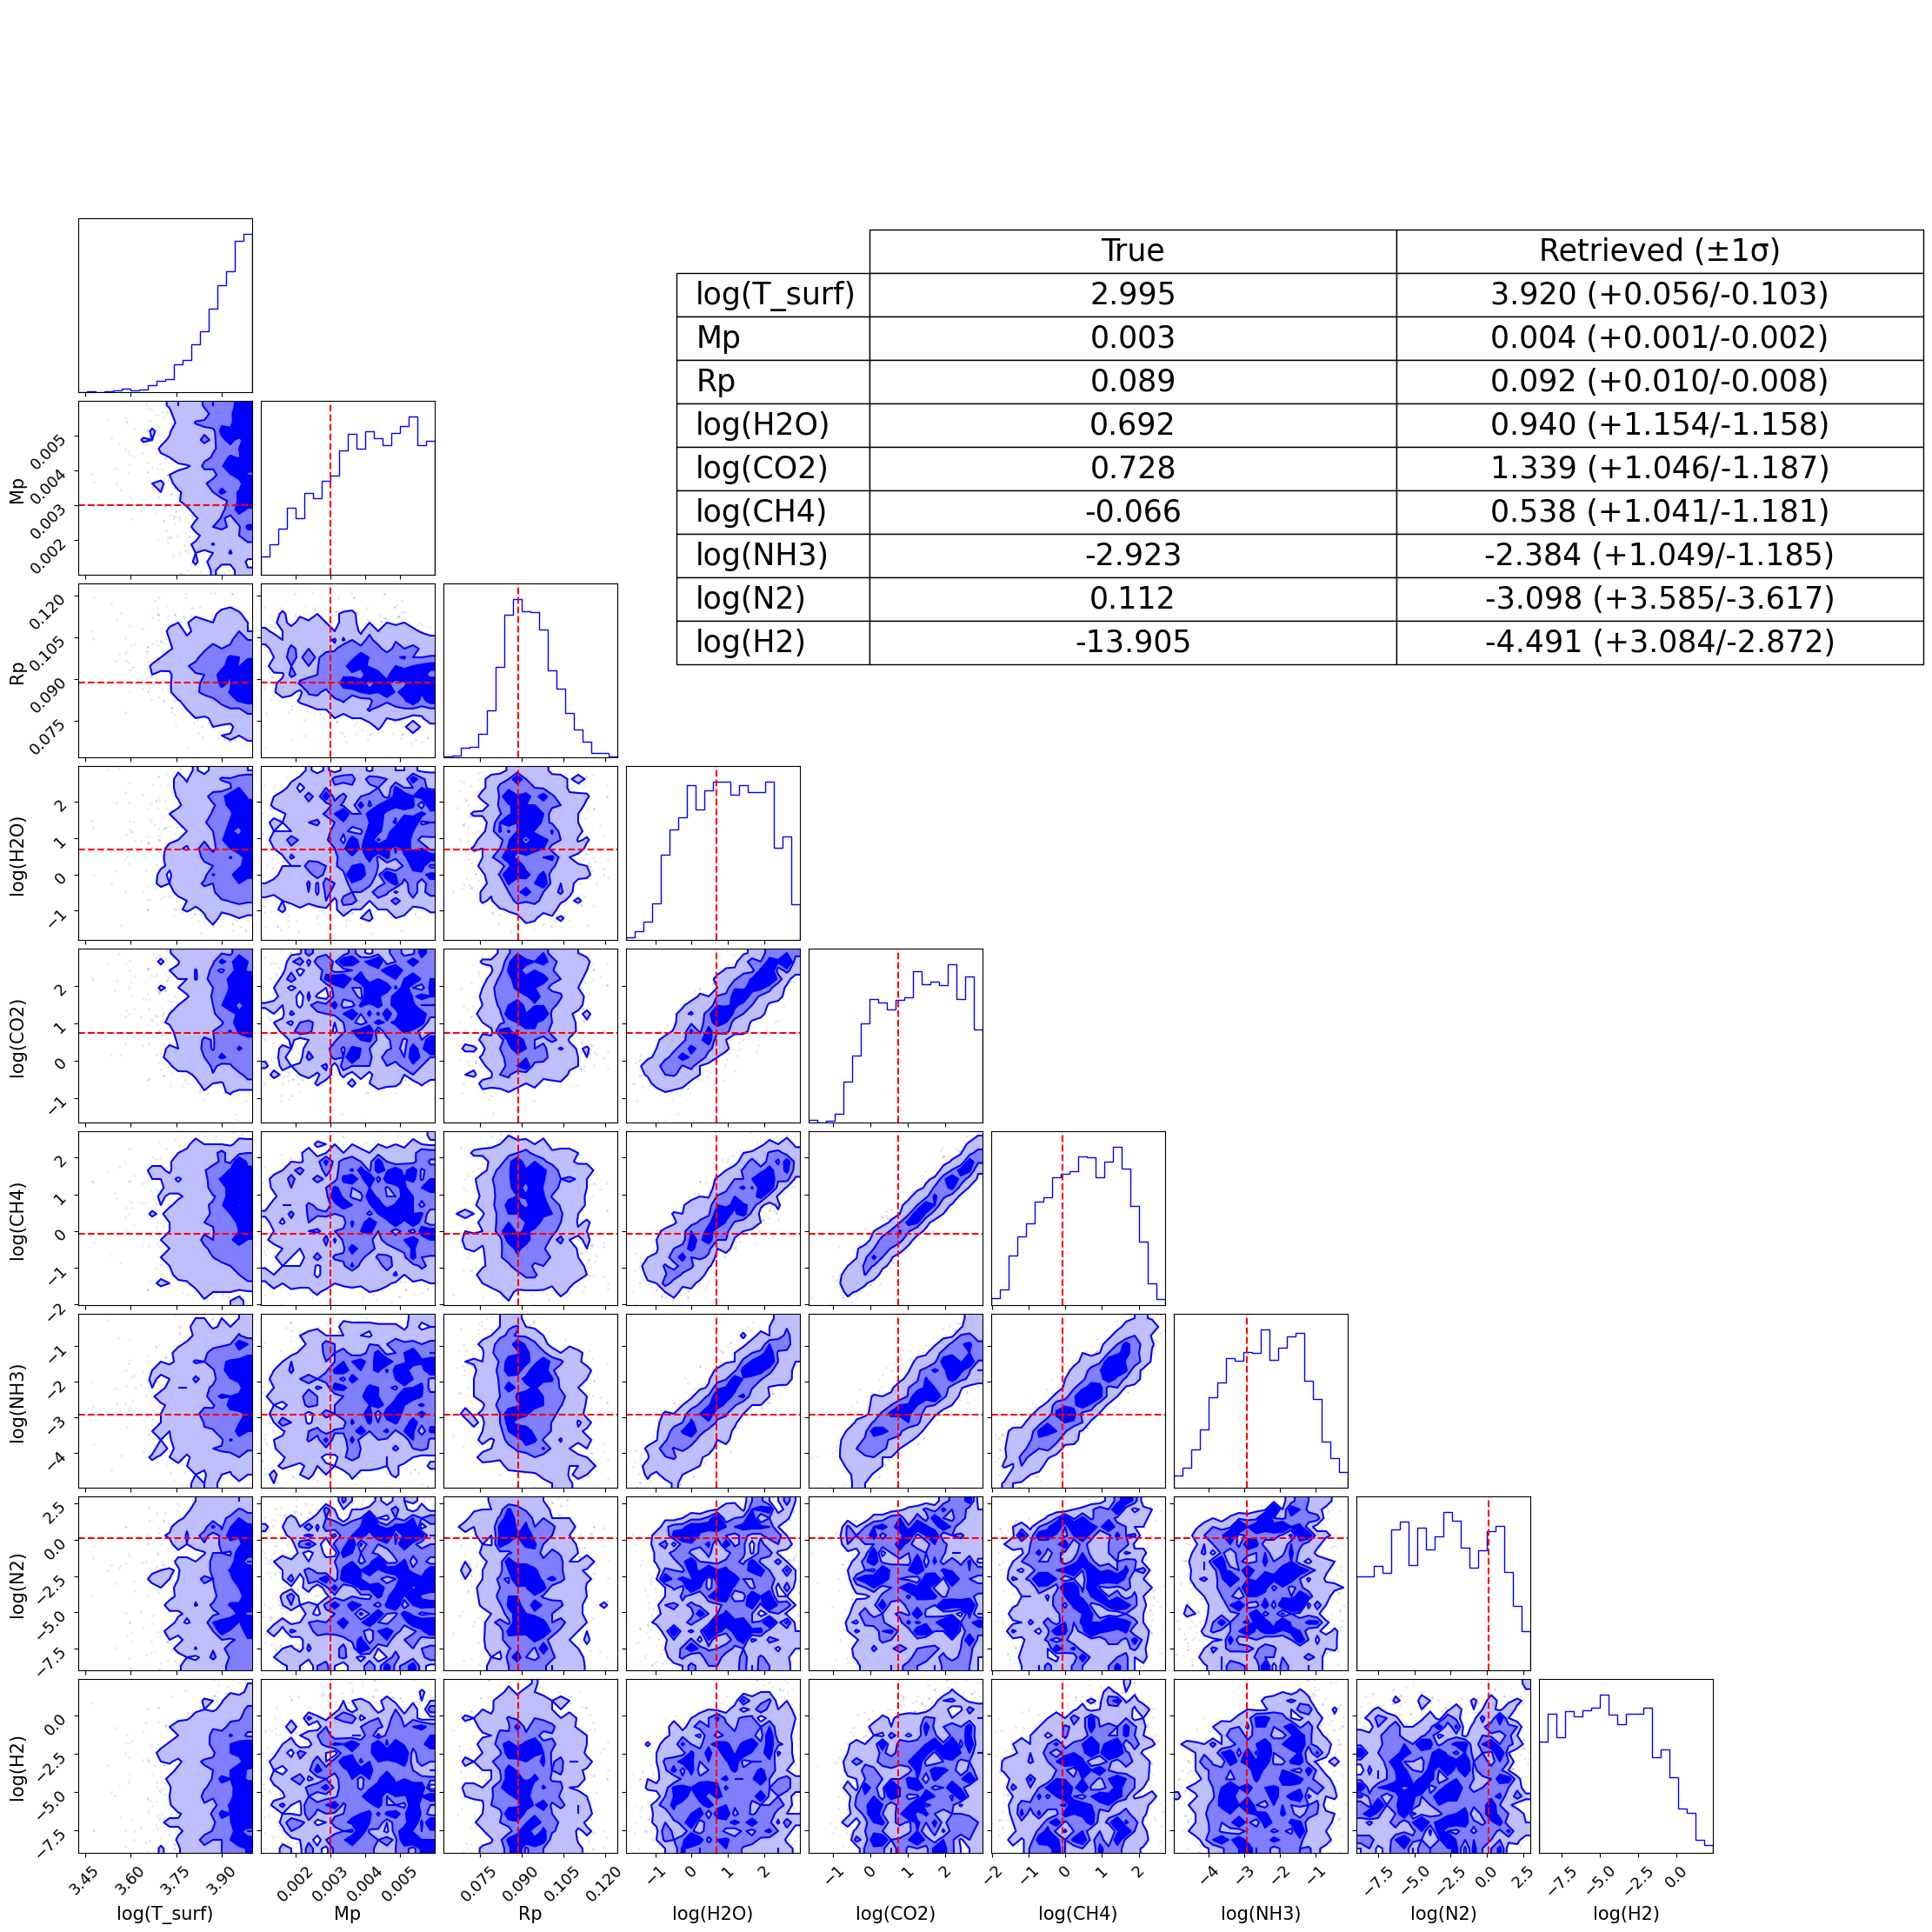

In [23]:
warnings.simplefilter('ignore')

directory = "NO_S_2_600"
data = posterior_distributions(f"{directory}/pew_output.dat")

H2 = data[1][:]
H2O = data[2][:]
CO2 = data[3][:]
CH4 = data[4][:]
NH3 = data[5][:]
N2 = data[6][:]
Rp = data[7][:]
Mp = data[8][:]
T_eff = data[21][:]
T_surf = data[14][:]

molecules = np.vstack([H2, H2O, CO2, CH4, NH3, N2]).T
H2_norm, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm = molecules.T

data = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
data_matrix = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
labels = ["log(T_surf)", "Mp", "Rp", "log(H2O)", "log(CO2)", "log(CH4)", "log(NH3)", "log(N2)", "log(H2)"]

temperature, pressure, _ = read_dat_file_with_headers(f"Forward-Files/{directory}/mixingratios.dat")
surface_temperature = np.max(temperature)
maximum_pressure_forward = np.max(pressure)

real_values = {
    "log(T_surf)":np.log10(surface_temperature),
    "Mp": 0.003,
    "Rp": 0.089,
    #"C/O": 0.397,
    "log(H2O)": np.log10(0.3959*maximum_pressure_forward),
    "log(CO2)": np.log10(0.430*maximum_pressure_forward),
    "log(CH4)": np.log10(0.069*maximum_pressure_forward),
    "log(NH3)": np.log10(9.59e-5*maximum_pressure_forward),
    "log(N2)": np.log10(0.104*maximum_pressure_forward),
    "log(H2)": np.log10(1e-15*maximum_pressure_forward),
}

# Generate corner plot without titles
figure = corner.corner(data_matrix,
                       labels=labels,
                       label_kwargs = {'fontsize':15},
                       show_titles=False,
                       color='blue',
                       fill_contours=True,
                       levels=(0.34, 0.68, 0.95))

axes = np.array(figure.axes).reshape((len(labels), len(labels)))

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=13)


# Draw red lines at true values
for i in range(len(labels)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:
            ax.axvline(real_values[labels[i]], color='red', linestyle='--')
        else:
            ax.axvline(real_values[labels[j]], color='red', linestyle='--')
            ax.axhline(real_values[labels[i]], color='red', linestyle='--')

# Compute medians and 1σ uncertainties
table_data = []
for i, label in enumerate(labels):
    median = np.median(data_matrix[:, i])
    lower = np.percentile(data_matrix[:, i], 16)
    upper = np.percentile(data_matrix[:, i], 84)
    err_minus = median - lower
    err_plus = upper - median
    true_val = real_values[label]
    result_str = f"{median:.3f} (+{err_plus:.3f}/-{err_minus:.3f})"
    table_data.append([f"{true_val:.3f}", result_str])

# Add table
table_labels = ["Parameter", "True Value", "Retrieved ±1σ"]
column_labels = ["True", "Retrieved (±1σ)"]
row_labels = labels

table_ax = figure.add_axes([0.65, 0.6, 0.3, 0.5])  # [left, bottom, width, height]
table_ax.axis('off')
the_table = table_ax.table(cellText=table_data,
                           rowLabels=row_labels,
                           colLabels=column_labels,
                           cellLoc='center',
                           loc='center')
the_table.scale(2, 3)
the_table.auto_set_font_size(False)
the_table.set_fontsize(25)

plt.savefig(f"Images/corner_{directory}.pdf", format="pdf", bbox_inches="tight")

# IW-2

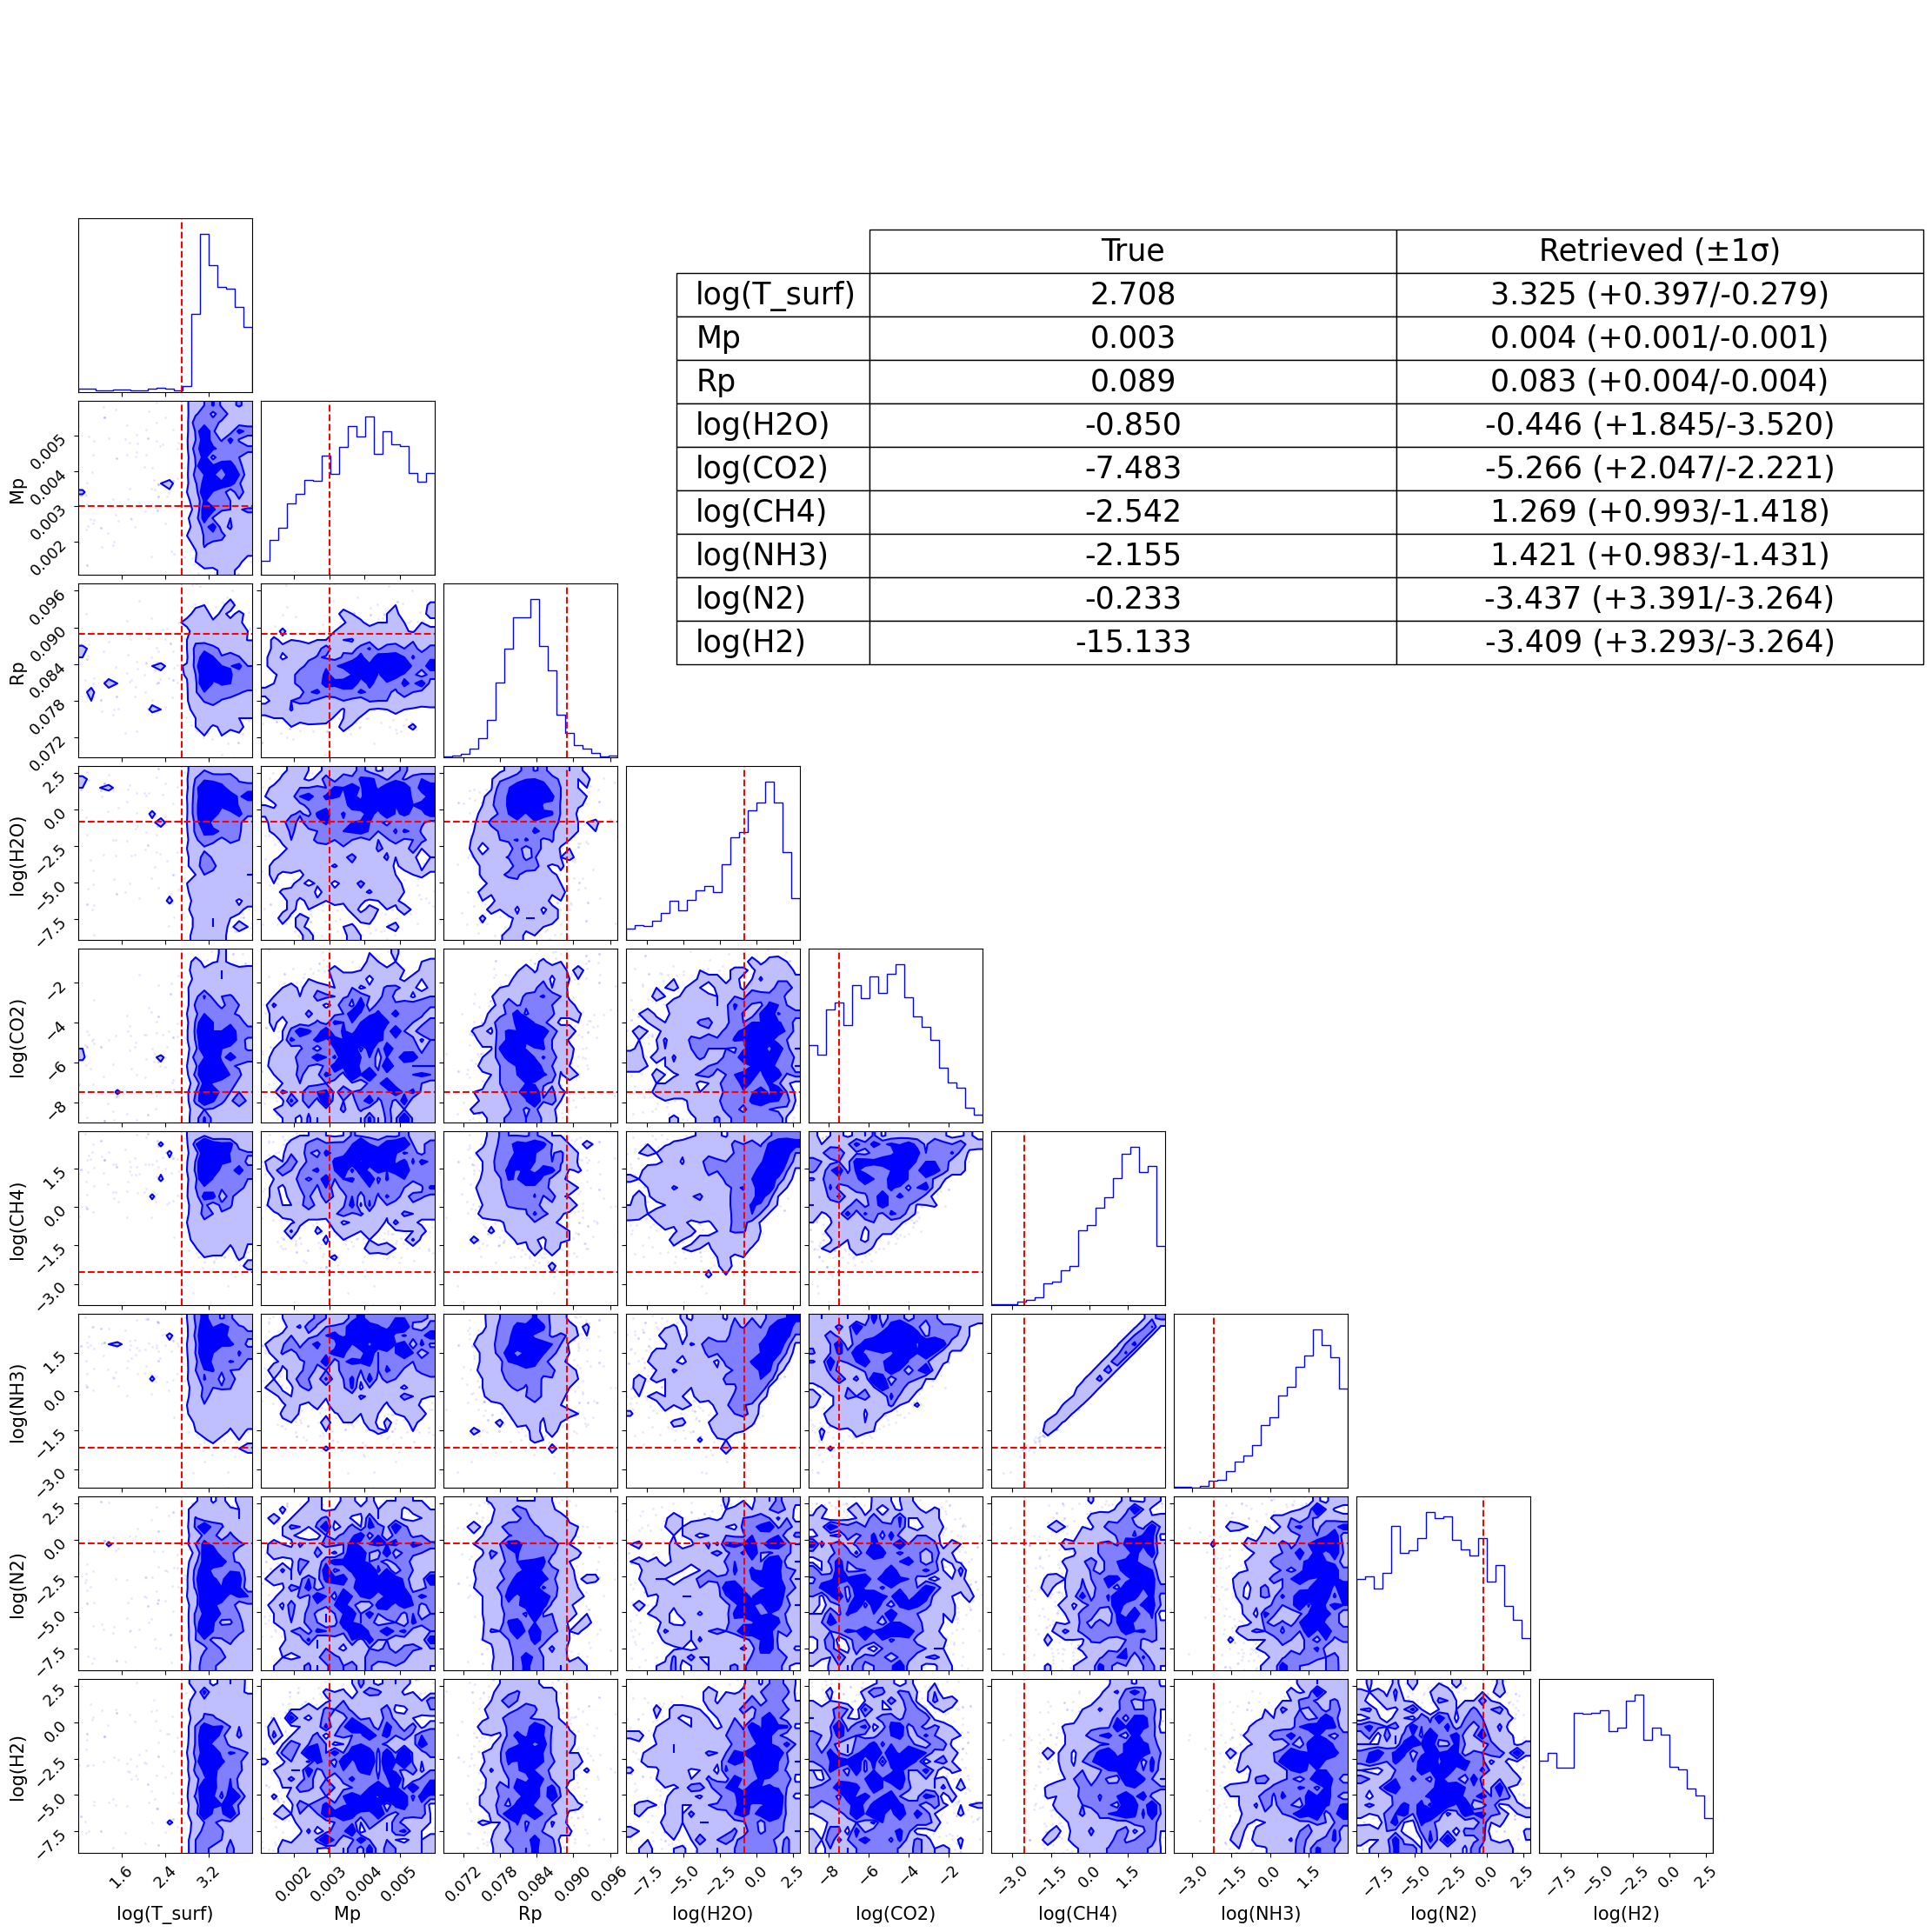

In [24]:
warnings.simplefilter('ignore')

directory = "NO_S_-2_600"
data = posterior_distributions(f"{directory}/pew_output.dat")

H2 = data[1][:]
H2O = data[2][:]
CO2 = data[3][:]
CH4 = data[4][:]
NH3 = data[5][:]
N2 = data[6][:]
Rp = data[7][:]
Mp = data[8][:]
T_eff = data[21][:]
T_surf = data[14][:]

molecules = np.vstack([H2, H2O, CO2, CH4, NH3, N2]).T
H2_norm, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm = molecules.T

data = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
data_matrix = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
labels = ["log(T_surf)", "Mp", "Rp", "log(H2O)", "log(CO2)", "log(CH4)", "log(NH3)", "log(N2)", "log(H2)"]

temperature, pressure, _ = read_dat_file_with_headers(f"Forward-Files/{directory}/mixingratios.dat")
surface_temperature = np.max(temperature)
maximum_pressure_forward = np.max(pressure)

real_values = {
    "log(P_surf)":np.log10(maximum_pressure_forward),
    "log(T_surf)":np.log10(surface_temperature),
    "Mp": 0.003,
    "Rp": 0.089,
    #"C/O": 0.02,
    "log(H2O)": np.log10(0.1918*maximum_pressure_forward),
    "log(CO2)": np.log10(4.47e-8*maximum_pressure_forward),
    "log(CH4)": np.log10(0.0039*maximum_pressure_forward),
    "log(NH3)": np.log10(0.0095*maximum_pressure_forward),
    "log(N2)": np.log10(0.795*maximum_pressure_forward),
    "log(H2)": np.log10(1e-15*maximum_pressure_forward),
}

# Generate corner plot without titles
figure = corner.corner(data_matrix,
                       labels=labels,
                       label_kwargs = {'fontsize':15},
                       show_titles=False,
                       color='blue',
                       fill_contours=True,
                       levels=(0.34, 0.68, 0.95))

axes = np.array(figure.axes).reshape((len(labels), len(labels)))

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=13)


# Draw red lines at true values
for i in range(len(labels)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:
            ax.axvline(real_values[labels[i]], color='red', linestyle='--')
        else:
            ax.axvline(real_values[labels[j]], color='red', linestyle='--')
            ax.axhline(real_values[labels[i]], color='red', linestyle='--')

# Compute medians and 1σ uncertainties
table_data = []
for i, label in enumerate(labels):
    median = np.median(data_matrix[:, i])
    lower = np.percentile(data_matrix[:, i], 16)
    upper = np.percentile(data_matrix[:, i], 84)
    err_minus = median - lower
    err_plus = upper - median
    true_val = real_values[label]
    result_str = f"{median:.3f} (+{err_plus:.3f}/-{err_minus:.3f})"
    table_data.append([f"{true_val:.3f}", result_str])

# Add table
table_labels = ["Parameter", "True Value", "Retrieved ±1σ"]
column_labels = ["True", "Retrieved (±1σ)"]
row_labels = labels

table_ax = figure.add_axes([0.65, 0.6, 0.3, 0.5])  # [left, bottom, width, height]
table_ax.axis('off')
the_table = table_ax.table(cellText=table_data,
                           rowLabels=row_labels,
                           colLabels=column_labels,
                           cellLoc='center',
                           loc='center')
the_table.scale(2, 3)
the_table.auto_set_font_size(False)
the_table.set_fontsize(25)

plt.savefig(f"Images/corner_{directory}.pdf", format="pdf", bbox_inches="tight")

# IW-4

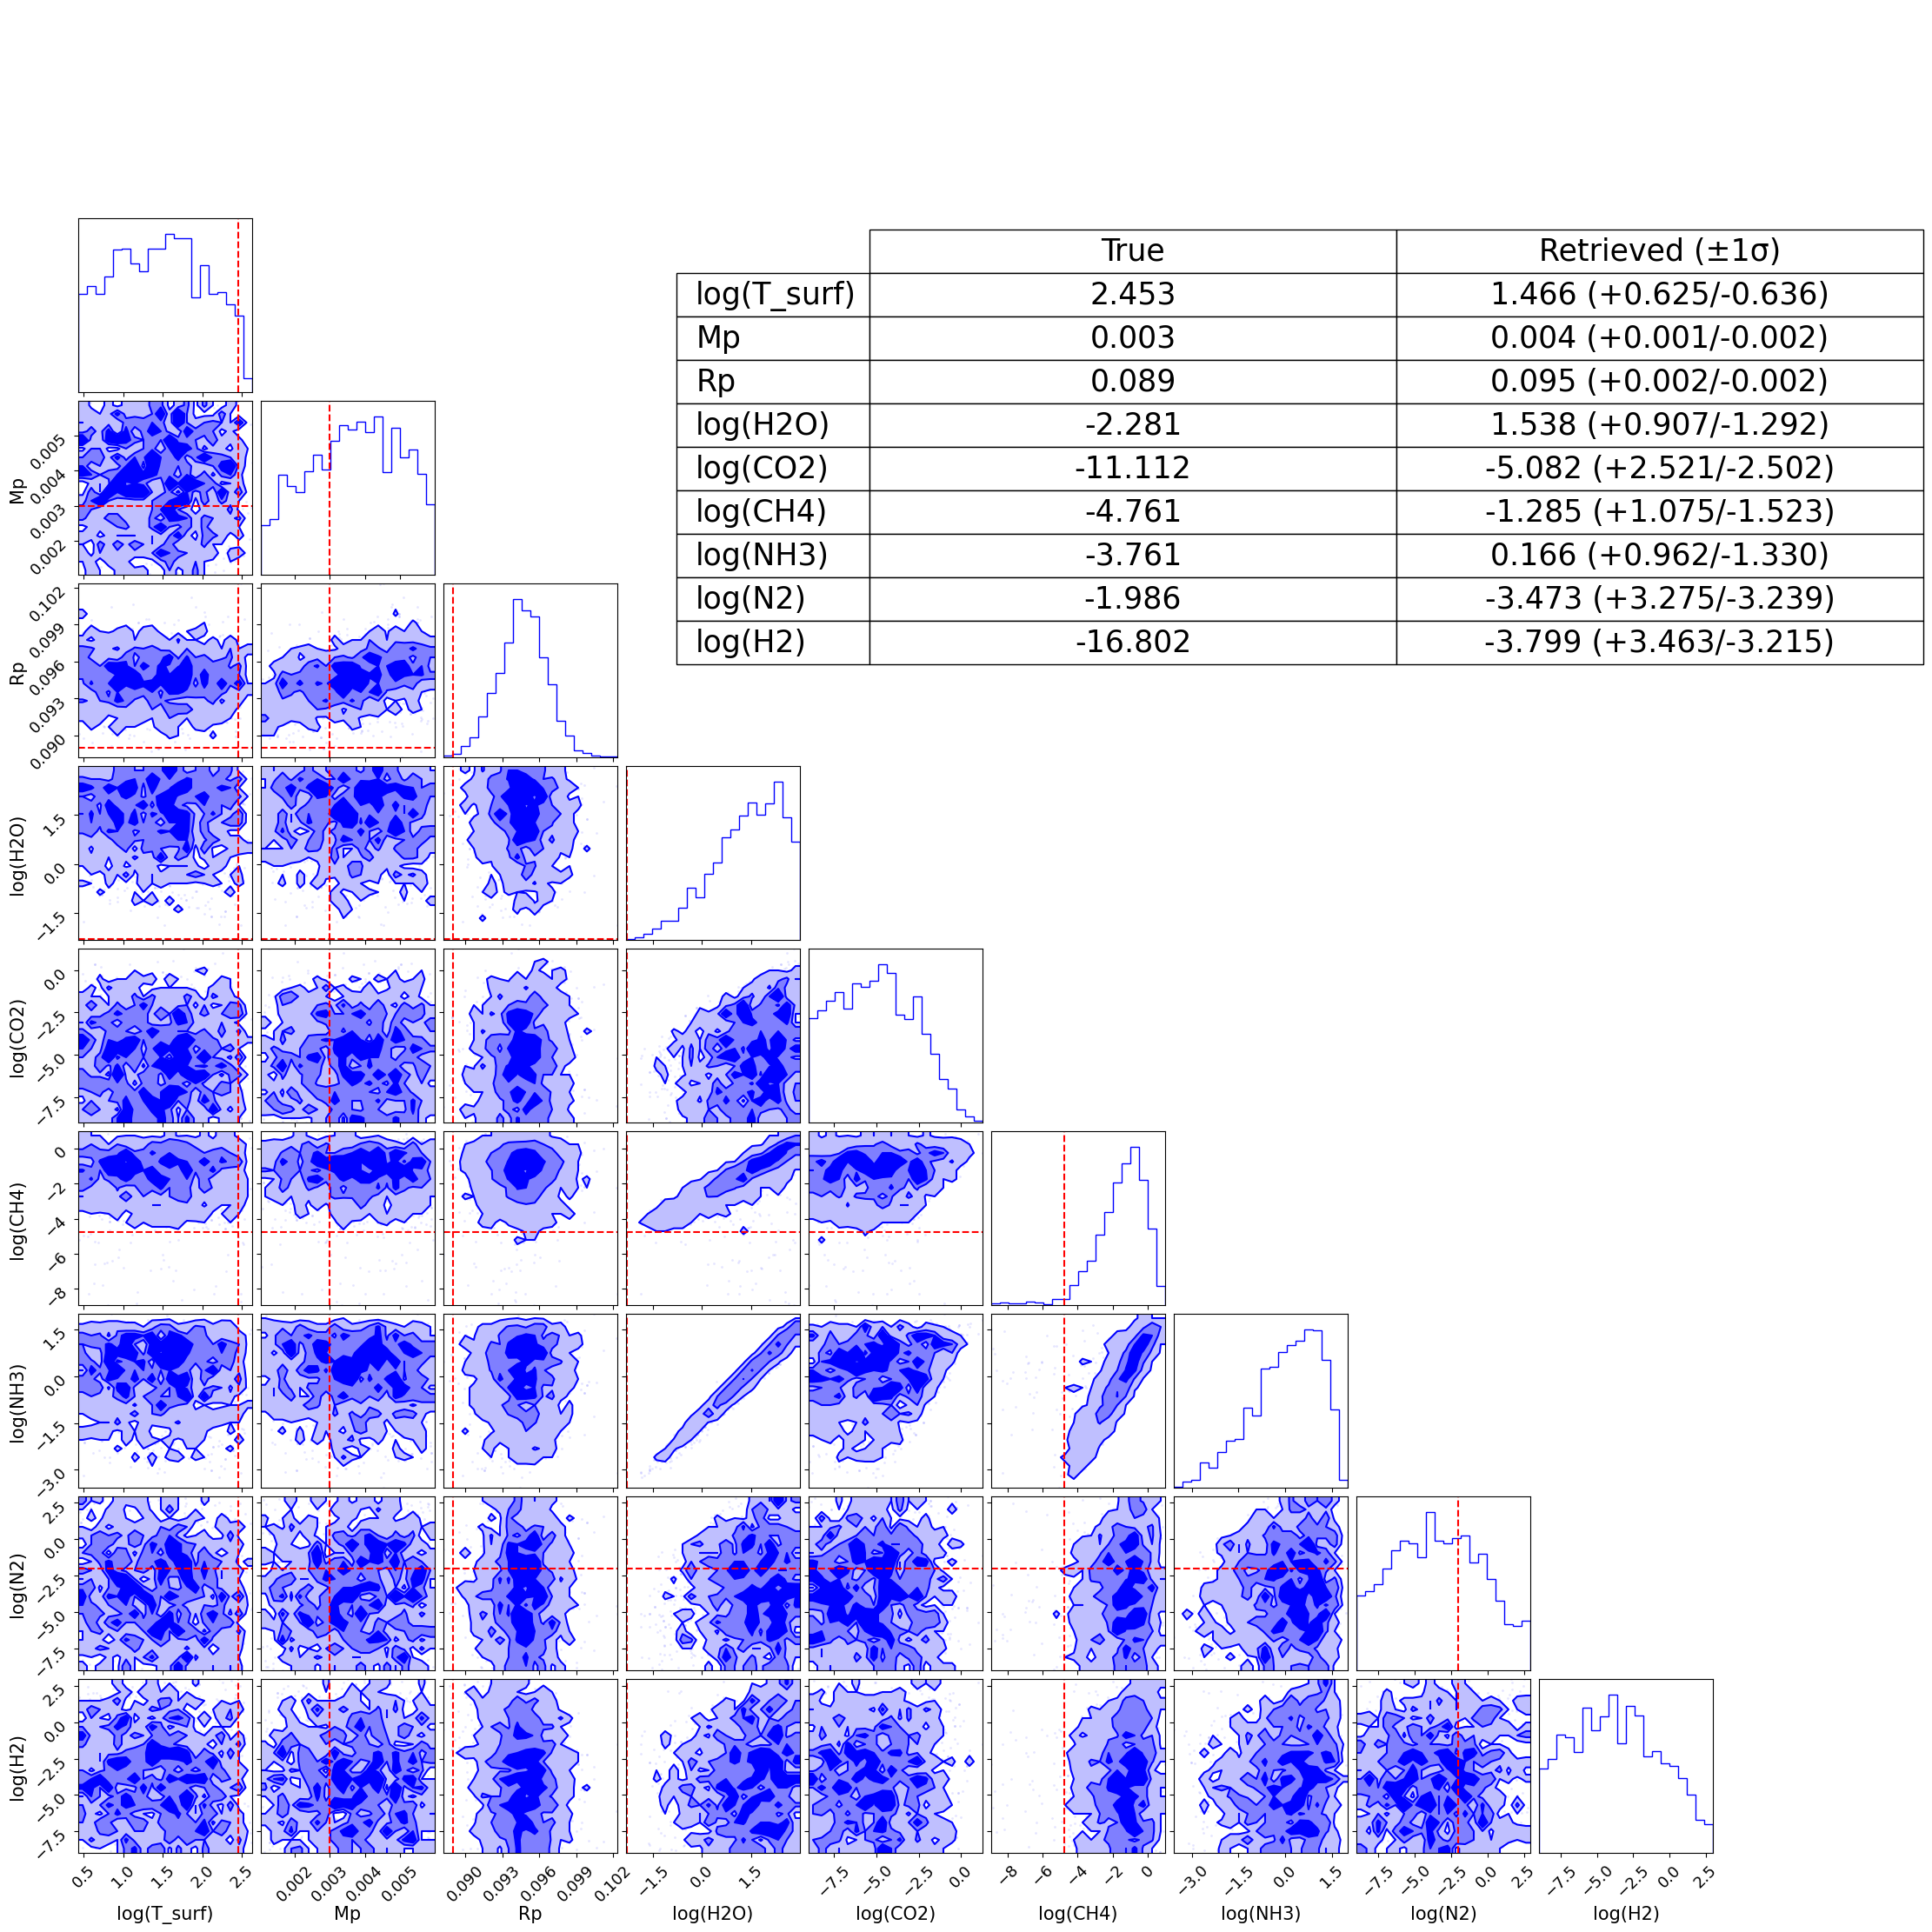

In [25]:
warnings.simplefilter('ignore')

directory = "NO_S_-4_600"
data = posterior_distributions(f"{directory}/pew_output.dat")

H2 = data[1][:]
H2O = data[2][:]
CO2 = data[3][:]
CH4 = data[4][:]
NH3 = data[5][:]
N2 = data[6][:]
Rp = data[7][:]
Mp = data[8][:]
T_eff = data[21][:]
T_surf = data[14][:]

molecules = np.vstack([H2, H2O, CO2, CH4, NH3, N2]).T
H2_norm, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm = molecules.T

data = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
data_matrix = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
labels = ["log(T_surf)", "Mp", "Rp", "log(H2O)", "log(CO2)", "log(CH4)", "log(NH3)", "log(N2)", "log(H2)"]

temperature, pressure, _ = read_dat_file_with_headers(f"Forward-Files/{directory}/mixingratios.dat")
surface_temperature = np.max(temperature)
maximum_pressure_forward = np.max(pressure)

real_values = {
    "log(T_surf)":np.log10(surface_temperature),
    "Mp": 0.003,
    "Rp": 0.089,
    #"C/O": 0.003,
    "log(H2O)": np.log10(0.3324*maximum_pressure_forward),
    "log(CO2)": np.log10(4.898e-10*maximum_pressure_forward),
    "log(CH4)": np.log10(0.0011*maximum_pressure_forward),
    "log(NH3)": np.log10(0.011*maximum_pressure_forward),
    "log(N2)": np.log10(0.6554*maximum_pressure_forward),
    "log(H2)": np.log10(1e-15*maximum_pressure_forward),
}

# Generate corner plot without titles
figure = corner.corner(data_matrix,
                       labels=labels,
                       label_kwargs = {'fontsize':15},
                       show_titles=False,
                       color='blue',
                       fill_contours=True,
                       levels=(0.34, 0.68, 0.95))

axes = np.array(figure.axes).reshape((len(labels), len(labels)))

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=13)


# Draw red lines at true values
for i in range(len(labels)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:
            ax.axvline(real_values[labels[i]], color='red', linestyle='--')
        else:
            ax.axvline(real_values[labels[j]], color='red', linestyle='--')
            ax.axhline(real_values[labels[i]], color='red', linestyle='--')

# Compute medians and 1σ uncertainties
table_data = []
for i, label in enumerate(labels):
    median = np.median(data_matrix[:, i])
    lower = np.percentile(data_matrix[:, i], 16)
    upper = np.percentile(data_matrix[:, i], 84)
    err_minus = median - lower
    err_plus = upper - median
    true_val = real_values[label]
    result_str = f"{median:.3f} (+{err_plus:.3f}/-{err_minus:.3f})"
    table_data.append([f"{true_val:.3f}", result_str])

# Add table
table_labels = ["Parameter", "True Value", "Retrieved ±1σ"]
column_labels = ["True", "Retrieved (±1σ)"]
row_labels = labels

table_ax = figure.add_axes([0.65, 0.6, 0.3, 0.5])  # [left, bottom, width, height]
table_ax.axis('off')
the_table = table_ax.table(cellText=table_data,
                           rowLabels=row_labels,
                           colLabels=column_labels,
                           cellLoc='center',
                           loc='center')
the_table.scale(2, 3)
the_table.auto_set_font_size(False)
the_table.set_fontsize(25)

plt.savefig(f"Images/corner_{directory}.pdf", format="pdf", bbox_inches="tight")

# IW-6

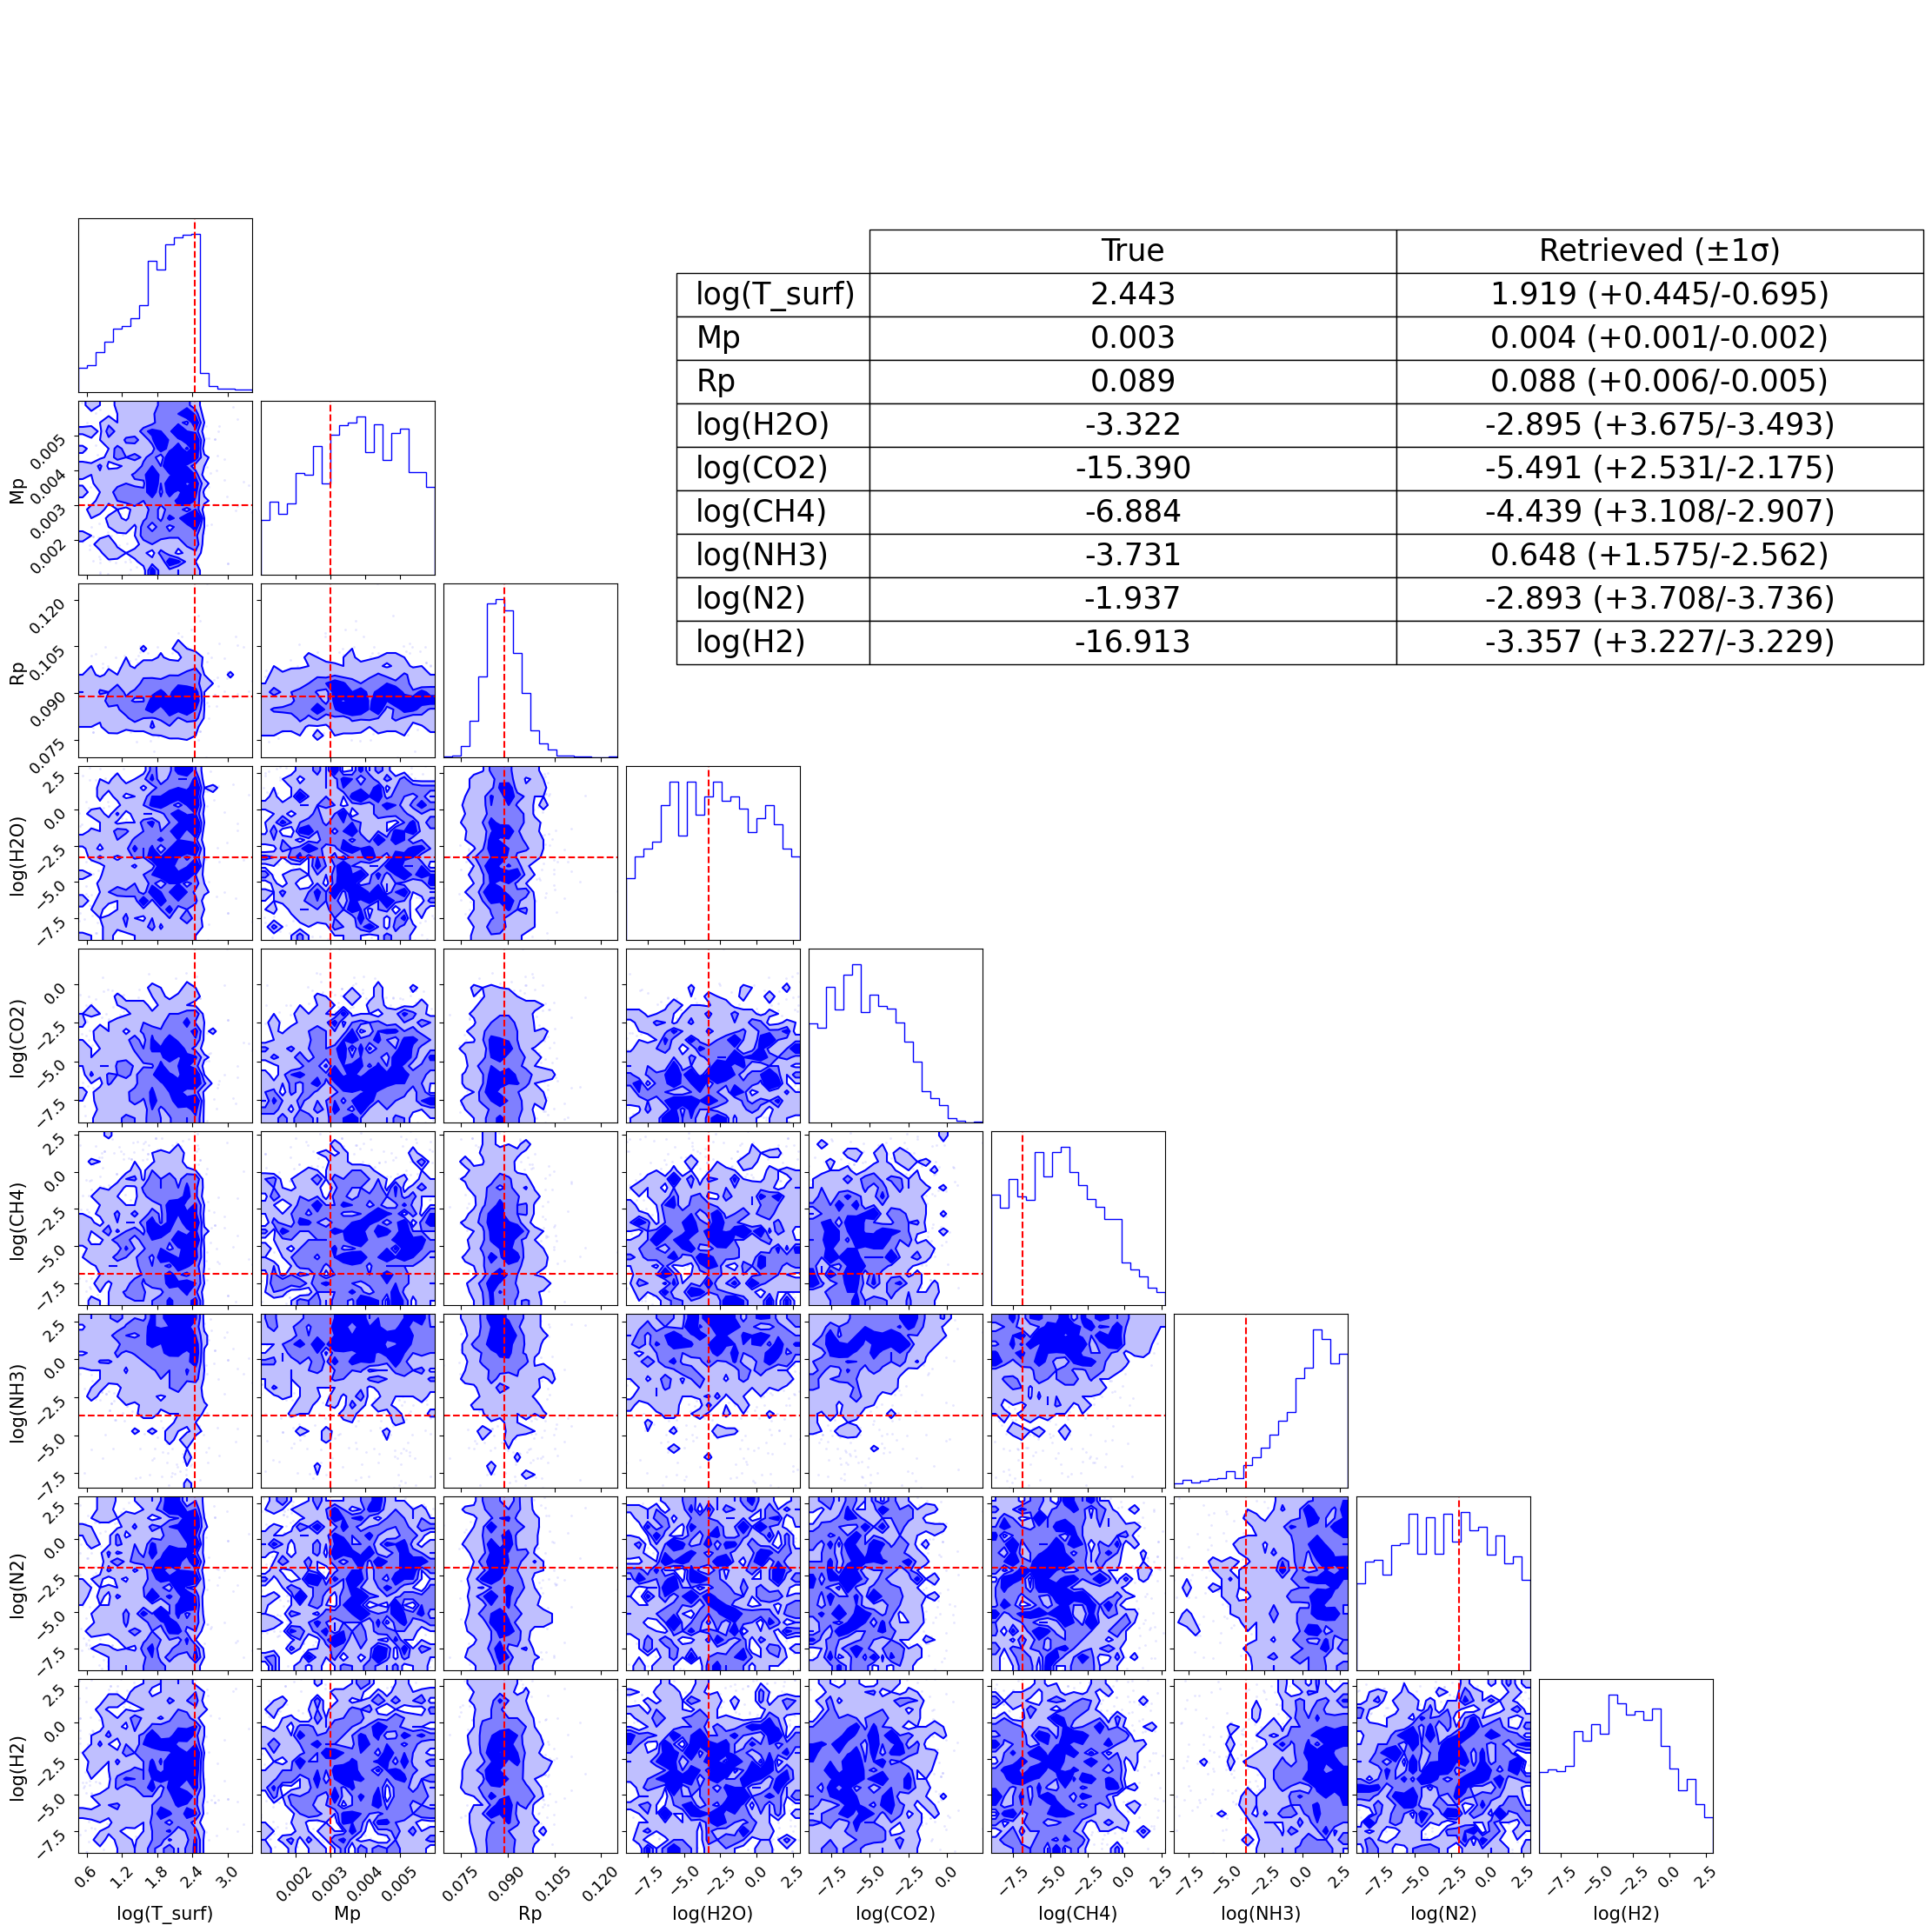

In [30]:
warnings.simplefilter('ignore')

directory = "NO_S_-6_600"
data = posterior_distributions(f"{directory}/pew_output.dat")

H2 = data[1][:]
H2O = data[2][:]
CO2 = data[3][:]
CH4 = data[4][:]
NH3 = data[5][:]
N2 = data[6][:]
Rp = data[7][:]
Mp = data[8][:]
T_eff = data[21][:]
T_surf = data[14][:]

molecules = np.vstack([H2, H2O, CO2, CH4, NH3, N2]).T
H2_norm, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm = molecules.T

data = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
data_matrix = np.vstack([T_surf, Mp, Rp, H2O_norm, CO2_norm, CH4_norm, NH3_norm, N2_norm, H2_norm]).T
labels = ["log(T_surf)", "Mp", "Rp", "log(H2O)", "log(CO2)", "log(CH4)", "log(NH3)", "log(N2)", "log(H2)"]

temperature, pressure, _ = read_dat_file_with_headers(f"Forward-Files/{directory}/mixingratios.dat")
surface_temperature = np.max(temperature)
maximum_pressure_forward = np.max(pressure)

real_values = {
    "log(T_surf)":np.log10(surface_temperature),
    "Mp": 0.003,
    "Rp": 0.089,
    #"C/O": 0.0003,
    "log(H2O)": np.log10(0.039*maximum_pressure_forward),
    "log(CO2)": np.log10(3.33e-14*maximum_pressure_forward),
    "log(CH4)": np.log10(1.07e-5*maximum_pressure_forward),
    "log(NH3)": np.log10(1.52e-2*maximum_pressure_forward),
    "log(N2)": np.log10(0.9456*maximum_pressure_forward),
    "log(H2)": np.log10(1e-15*maximum_pressure_forward),
}

# Generate corner plot without titles
figure = corner.corner(data_matrix,
                       labels=labels,
                       label_kwargs = {'fontsize':15},
                       show_titles=False,
                       color='blue',
                       fill_contours=True,
                       levels=(0.34, 0.68, 0.95))

axes = np.array(figure.axes).reshape((len(labels), len(labels)))

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=13)


# Draw red lines at true values
for i in range(len(labels)):
    for j in range(i + 1):
        ax = axes[i, j]
        if i == j:
            ax.axvline(real_values[labels[i]], color='red', linestyle='--')
        else:
            ax.axvline(real_values[labels[j]], color='red', linestyle='--')
            ax.axhline(real_values[labels[i]], color='red', linestyle='--')

# Compute medians and 1σ uncertainties
table_data = []
for i, label in enumerate(labels):
    median = np.median(data_matrix[:, i])
    lower = np.percentile(data_matrix[:, i], 16)
    upper = np.percentile(data_matrix[:, i], 84)
    err_minus = median - lower
    err_plus = upper - median
    true_val = real_values[label]
    result_str = f"{median:.3f} (+{err_plus:.3f}/-{err_minus:.3f})"
    table_data.append([f"{true_val:.3f}", result_str])

# Add table
table_labels = ["Parameter", "True Value", "Retrieved ±1σ"]
column_labels = ["True", "Retrieved (±1σ)"]
row_labels = labels

table_ax = figure.add_axes([0.65, 0.6, 0.3, 0.5])  # [left, bottom, width, height]
table_ax.axis('off')
the_table = table_ax.table(cellText=table_data,
                           rowLabels=row_labels,
                           colLabels=column_labels,
                           cellLoc='center',
                           loc='center')
the_table.scale(2, 3)
the_table.auto_set_font_size(False)
the_table.set_fontsize(25)

plt.savefig(f"Images/corner_{directory}.pdf", format="pdf", bbox_inches="tight")